# Application of design best practices to COVID-19 dataset 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os,sys
import scanpy as sc 
import pandas as pd
import numpy as np
import milopy
import scipy
import anndata

import scvi
import shutil

from oor_benchmark.methods.scArches_milo import run_milo

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

sns.set_context('talk')
from matplotlib.pyplot import rc_context

Global seed set to 0


In [3]:
figdir = '/home/jovyan/mount/gdrive/diff2atlas/figures/COVID_analysis/'
if not os.path.exists(figdir):
    os.mkdir(figdir)
sc.settings.figdir = figdir


In [4]:
## r2py setup
import rpy2.rinterface_lib.callbacks
import logging
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)


In [5]:
%load_ext rpy2.ipython

In [6]:
%%R
library(tidyverse)
library(reshape2)
library(patchwork)
library(ggrastr)

remove_x_axis <- function(){
  theme(axis.text.x = element_blank(), axis.ticks.x = element_blank(), axis.title.x = element_blank())  
}

remove_y_axis <- function(){
  theme(axis.text.y = element_blank(), axis.ticks.y = element_blank(), axis.title.y = element_blank())  
}

System has not been booted with systemd as init system (PID 1). Can't operate.
Failed to create bus connection: Host is down


In [7]:
## Define color palette
pal = sns.color_palette('Paired').as_hex()
design_palette = {'ACR':pal[3], 'CR':pal[7], 'AR':pal[9], 'joint_CR':pal[6]}
design_palette_df = pd.DataFrame(design_palette.values(), index =design_palette.keys() )
design_palette_df.columns = ['color']

In [8]:
%%R -i design_palette_df -i figdir
design_palette = setNames(design_palette_df$color, rownames(design_palette_df))

In [19]:
from adjustText import adjust_text
import matplotlib.patheffects as pe

def gen_mpl_labels(
    adata, groupby, exclude=(), ax=None, adjust_kwargs=None, text_kwargs=None
):
    if adjust_kwargs is None:
        adjust_kwargs = {"text_from_points": False}
    if text_kwargs is None:
        text_kwargs = {}

    medians = {}

    for g, g_idx in adata.obs.groupby(groupby).groups.items():
        if g in exclude:
            continue
        medians[g] = np.median(adata[g_idx].obsm["X_umap"], axis=0)

    if ax is None:
        texts = [
            plt.text(x=x, y=y, s=k, **text_kwargs) for k, (x, y) in medians.items()
        ]
    else:
        texts = [ax.text(x=x, y=y, s=k, **text_kwargs) for k, (x, y) in medians.items()]

    adjust_text(texts, **adjust_kwargs)

In [10]:
def plot_w_ggplot(r_fct_str, args, figdir='.', pl_name='plot', pl_width=8, pl_height=8):

    import rpy2.robjects.pandas2ri
    import rpy2.robjects.numpy2ri
    from rpy2.robjects.packages import STAP

    r_pkg = STAP(r_fct_str, "r_pkg")
    #this was needed for the code to run on jhub
    #if you have a different version of rpy2 you may not need these two lines
    rpy2.robjects.pandas2ri.activate()
    rpy2.robjects.numpy2ri.activate()
    
    # PASS OBJECTS INTO FUNCTION
    pl = r_pkg.plot_func(args)
    
    ggsave_str = '''
    save_plot <- function(pl, figdir, pl_name, pl_width, pl_height){
        pl + 
        ggsave(file.path(figdir, paste0(pl_name, ".png")), width=pl_width, height=pl_height)  +
        ggsave(file.path(figdir, paste0(pl_name, ".pdf")), width=pl_width, height=pl_height)
    }
    
    '''
    r_save = STAP(ggsave_str, "r_save")
    r_save.save_plot(pl, figdir, pl_name=pl_name, pl_width=pl_width, pl_height=pl_height)
    

## Latent embedding workflow

Train reference scVI models (on cluster)

```bash

outdir=/lustre/scratch126/cellgen/team205/ed6/PBMC_COVID/

## Train reference models
# A = Atlas (for ACR design - scArches)
# C = Control (for CR design - scArches)
# PC = Perturbation+Control (for CR design - scVI)
# PAC = Perturbation+Atlas+Control (for ACR design - scVI)
for d in 'A' 'C' 'PC' 'PAC'; do     
    echo "python oor_design_reproducibility/src/4_COVID_design/COVID_train_references.py ${d} --datadir ${outdir}" | \
    bsub -G teichlab -o logfile-scvi-%J.out -e logfile-scvi-%J.err -q gpu-normal -M50000 -R "select[mem>50000] rusage[mem=50000]" -gpu "mode=shared:j_exclusive=no:gmem=6000:num=1"
done
```

Map query datasets with scArches

```bash

## ACR design - scArches
echo "python oor_design_reproducibility/src/4_COVID_design/COVID_map_query.py model_reference_A PC --datadir ${outdir}" | \
bsub -G teichlab -o logfile-scarches-%J.out -e logfile-scarches-%J.err -q gpu-normal -M25000 -R "select[mem>25000] rusage[mem=25000]" -gpu "mode=shared:j_exclusive=no:gmem=6000:num=1"

# CR design - scArches
echo "python COVID_map_query.py model_reference_C P --datadir ${outdir}" | \
    bsub -G teichlab -o logfile-scarches-%J.out -e logfile-scarches-%J.err -q gpu-normal -M25000 -R "select[mem>25000] rusage[mem=25000]" -gpu "mode=shared:j_exclusive=no:gmem=6000:num=1"
```

## Parse outputs into alternative reference designs

In [9]:
data_dir = '/lustre/scratch126/cellgen/team205/ed6/PBMC_COVID/'

In [4]:
adata_atlas = sc.read_h5ad(data_dir + 'PBMC_COVID.subsample500cells.atlas.h5ad')
adata_covid = sc.read_h5ad(data_dir + 'PBMC_COVID.subsample500cells.covid.h5ad')
adata_ctrl = sc.read_h5ad(data_dir + 'PBMC_COVID.subsample500cells.ctrl.h5ad')
adata_dict = {'A': adata_atlas, 'P': adata_covid, 'C': adata_ctrl}

Global seed set to 0


In [7]:
def _read_design(model_query_dir, n_neighbors=100):
    ref_string = model_query_dir.split('ref')[-1]
    query_string = model_query_dir.split('_ref')[0].split('_')[-1]
    model_reference_dir = f'model_reference_{ref_string}'

    # Make merged anndata object
    print("Merging anndatas...\n")
    adata_design = anndata.concat([adata_dict[d] for d in ref_string] + [adata_dict[d] for d in query_string],
        label='dataset_group',
        keys = [d for d in ref_string] + [d for d in query_string]
        )

    print("Loading trained models...\n")
    try:
        vae_reference = scvi.model.SCVI.load(outdir + model_reference_dir + f'_scvi{scvi.__version__}')
    except:
        scvi.model.SCVI.convert_legacy_save(outdir + model_reference_dir, outdir + model_reference_dir + f'_scvi{scvi.__version__}', overwrite=True)
        shutil.copyfile(outdir + model_reference_dir + '/adata.h5ad', outdir + model_reference_dir + f'_scvi{scvi.__version__}/adata.h5ad')
        vae_reference = scvi.model.SCVI.load(outdir + model_reference_dir + f'_scvi{scvi.__version__}')
    try:
        vae_query = scvi.model.SCVI.load( outdir + model_query_dir + f'_scvi{scvi.__version__}')
    except:
        scvi.model.SCVI.convert_legacy_save(outdir + model_query_dir, outdir + model_query_dir + f'_scvi{scvi.__version__}', overwrite=True)
        shutil.copyfile(outdir + model_query_dir + '/adata.h5ad', outdir + model_query_dir + f'_scvi{scvi.__version__}/adata.h5ad')
        vae_query = scvi.model.SCVI.load( outdir + model_query_dir + f'_scvi{scvi.__version__}')

    model_obs_names = vae_reference.adata.obs_names.tolist() + vae_query.adata.obs_names.tolist()
    if all(model_obs_names == adata_design.obs_names):
        adata_design.obsm['X_scVI'] = np.vstack([
            vae_reference.get_latent_representation(),
            vae_query.get_latent_representation(),
            ])
    else:
        raise ValueError("Cell names don't match order in model")

    ## Remove atlas, if present
    adata_design = adata_design[adata_design.obs['dataset_group'] != 'A'].copy()

    ## Compute KNN graph
    print("Computing KNN graph...\n")
    sc.pp.neighbors(adata_design, use_rep='X_scVI', n_neighbors=n_neighbors)

    ## Run UMAP
    print("Running UMAP...\n")
    sc.tl.umap(adata_design)

    ## Save 
    file_name = f"PBMC_COVID.subsample500cells.design.{model_query_dir.split('model_')[-1]}.h5ad"
    print(f"Saving to {file_name}...\n")
    adata_design.write_h5ad(outdir + file_name)

def _read_design_scvi(model_reference_dir, n_neighbors=100):
    ref_string = model_reference_dir.split('_')[-1]
    model_reference_dir = f'model_reference_{ref_string}'

    # Make merged anndata object
    print("Merging anndatas...\n")
    adata_design = anndata.concat([adata_dict[d] for d in ref_string],
        label='dataset_group',
        keys = [d for d in ref_string]
        )

    print("Loading trained models...\n")
    try:
        vae_reference = scvi.model.SCVI.load(outdir + model_reference_dir + f'_scvi{scvi.__version__}')
    except:
        scvi.model.SCVI.convert_legacy_save(outdir + model_reference_dir, outdir + model_reference_dir + f'_scvi{scvi.__version__}', overwrite=True)
        shutil.copyfile(outdir + model_reference_dir + '/adata.h5ad', outdir + model_reference_dir + f'_scvi{scvi.__version__}/adata.h5ad')
        vae_reference = scvi.model.SCVI.load(outdir + model_reference_dir + f'_scvi{scvi.__version__}')
    
    model_obs_names = vae_reference.adata.obs_names.tolist() 
    if all(model_obs_names == adata_design.obs_names):
        adata_design.obsm['X_scVI'] = vae_reference.get_latent_representation()
    else:
        raise ValueError("Cell names don't match order in model")

    ## Remove atlas, if present
    adata_design = adata_design[adata_design.obs['dataset_group'] != 'A'].copy()

    ## Compute KNN graph
    print("Computing KNN graph...\n")
    sc.pp.neighbors(adata_design, use_rep='X_scVI', n_neighbors=n_neighbors)

    ## Run UMAP
    print("Running UMAP...\n")
    sc.tl.umap(adata_design)

    ## Save 
    file_name = f"PBMC_COVID.subsample500cells.design.{model_reference_dir.split('model_reference')[-1]}.h5ad"
    print(f"Saving to {file_name}...\n")
    adata_design.write_h5ad(outdir + file_name)


In [8]:
for mq in [x for x in os.listdir(outdir) if x.startswith('model_query_') and 'scvi' not in x]:
    _read_design(mq)

for mq in ['model_reference_PC', 'model_reference_PAC']:
    _read_design_scvi(mq)


Merging anndatas...

Loading trained models...

INFO     File /lustre/scratch117/cellgen/team205/ed6/PBMC_COVID/model_reference_A_scvi0.16.2/
         model.pt already downloaded                                                         
INFO     No backup URL provided for missing file /lustre/scratch117/cellgen/team205/ed6/PBMC_
         COVID/model_query_PC_refA_scvi0.16.2/model.pt                                       
INFO     File /lustre/scratch117/cellgen/team205/ed6/PBMC_COVID/model_query_PC_refA_scvi0.16.
         2/model.pt already downloaded                                                       
Computing KNN graph...

Running UMAP...

Saving to {file_name}...

Merging anndatas...

Loading trained models...

INFO     No backup URL provided for missing file /lustre/scratch117/cellgen/team205/ed6/PBMC_
         COVID/model_reference_C_scvi0.16.2/model.pt                                         
INFO     File /lustre/scratch117/cellgen/team205/ed6/PBMC_COVID/model_reference_C_scv

## Milo analysis

In [11]:
data_dir = '/lustre/scratch126/cellgen/team205/ed6/PBMC_COVID/'
adata_atlas = sc.read_h5ad(data_dir + 'PBMC_COVID.subsample500cells.atlas.h5ad', backed='r')

## Load dataset specific obs
query_batch = '/nfs/team205/ed6/data/PBMC_CZI_integration_filtered/10_1038_s41591_021_01329_2.h5ad'
stephenson_obs = sc.read_h5ad(query_batch, backed='r').obs.copy()

### Prepare ACR design object

In [12]:
adata = sc.read_h5ad(data_dir + 'PBMC_COVID.subsample500cells.design.query_PC_refA.h5ad')

## Add dataset specific obs 
new_obs = stephenson_obs.loc[[x.split('10_1038_s41591_021_01329_2-')[-1] for x in adata.obs_names]]
new_obs.index = adata.obs_names
adata.obs = pd.concat([new_obs.loc[:,~new_obs.columns.isin(adata.obs.columns)], adata.obs], 1)

## Add interferon signature 
adata.layers['counts'] = adata.X.copy()
sc.pp.normalize_per_cell(adata)
sc.pp.log1p(adata)

adata.var = adata_atlas.var.loc[adata.var_names]
adata.var_names = adata.var['gene_name'].values
## Taken from https://www.nature.com/articles/s41586-021-04345-x
ifn_signature_genes = [
    'BST2', 'CMPK2', 'EIF2AK2', 'EPSTI1', 'HERC5', 'IFI35', 'IFI44L', 'IFI6', 
    'IFIT3', 'ISG15', 'LY6E', 'MX1', 'MX2', 'OAS1', 'OAS2', 'PARP9', 'PLSCR1', 
    'SAMD9', 'SAMD9L', 'SP110', 'STAT1', 'TRIM22', 'UBE2L6', 'XAF1', 'IRF7'
    ]

sc.tl.score_genes(adata, ifn_signature_genes, score_name='IFN_signature')

/tmp/ipykernel_8576/1888922573.py:6: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  adata.obs = pd.concat([new_obs.loc[:,~new_obs.columns.isin(adata.obs.columns)], adata.obs], 1)
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/anndata/_core/anndata.py:895: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    ['FAM87B', 'LINC00115', 'FAM41C', 'SAMD11', 'NOC2L']

    Inferred to be: categorical

  names = self._prep_dim_index(names, "var")


### Prepare CR design object

In [13]:
adata_c = sc.read_h5ad(data_dir + 'PBMC_COVID.subsample500cells.design._PC.h5ad')
new_obs = stephenson_obs.loc[[x.split('10_1038_s41591_021_01329_2-')[-1] for x in adata_c.obs_names]]
new_obs.index = adata_c.obs_names
adata_c.obs = pd.concat([new_obs.loc[:,~new_obs.columns.isin(adata_c.obs.columns)], adata_c.obs], 1)
adata_c.obs['IFN_signature'] = adata.obs.loc[adata_c.obs_names, 'IFN_signature']

adata_c.layers['counts'] = adata_c.X.copy()
sc.pp.normalize_per_cell(adata_c)
sc.pp.log1p(adata_c)

/tmp/ipykernel_8576/3586043762.py:4: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  adata_c.obs = pd.concat([new_obs.loc[:,~new_obs.columns.isin(adata_c.obs.columns)], adata_c.obs], 1)


### Run differential analysis

In [14]:
run_milo(adata, 'P', 'C', sample_col='sample_id', annotation_col='cell_type', design='~Site+is_query')
milopy.utils.annotate_nhoods_continuous(adata, "IFN_signature")
milopy.utils.annotate_nhoods(adata, 'author_cell_type')

/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/scipy/sparse/_base.py:665: RuntimeWarning: invalid value encountered in divide
  return np.true_divide(self.todense(), other)
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/rpy2/robjects/vectors.py:1010: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/pandas/core/arrays/datetimes.py:2192: PytzUsageWarning: The zone attribute is specific to pytz's interface; please migrate to a new time zone provider. For more details on how to do so, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.ht

In [15]:
run_milo(adata_c, 'P', 'C', sample_col='sample_id', annotation_col='cell_type', design='~Site+is_query')
milopy.utils.annotate_nhoods(adata_c, 'author_cell_type')
milopy.utils.annotate_nhoods_continuous(adata_c, "IFN_signature")

/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/scipy/sparse/_base.py:665: RuntimeWarning: invalid value encountered in divide
  return np.true_divide(self.todense(), other)


### Add broad annotation labels

In [16]:
anno_labels = adata.obs['author_cell_type'].unique()
anno_groups = {}
anno_groups['B_cell'] = [x for x in adata.obs['author_cell_type'].unique() if x.startswith('B_')]
anno_groups['HSPC'] = [x for x in adata.obs['author_cell_type'].unique() if x.startswith('HSC_')]
anno_groups['CD14_mono'] =[x for x in adata.obs['author_cell_type'].unique() if 'CD14_mono' in x]
anno_groups['CD16_mono'] =[x for x in adata.obs['author_cell_type'].unique() if 'CD16_mono' in x]
anno_groups['CD4_T'] =[x for x in adata.obs['author_cell_type'].unique() if x.startswith("CD4.")]
anno_groups['CD8_T'] =[x for x in adata.obs['author_cell_type'].unique() if x.startswith("CD8.")]
anno_groups['ILC'] =[x for x in adata.obs['author_cell_type'].unique() if x.startswith("ILC")]
anno_groups['Plasma_cell'] =[x for x in adata.obs['author_cell_type'].unique() if x.startswith("Plasma_cell")]

for x in anno_labels: 
    if x not in sum(anno_groups.values(), []):
        anno_groups[x] = [x]

anno_labels_dict = {x:k for k,v in anno_groups.items() for x in v}

adata.obs['author_cell_type_broad'] = [anno_labels_dict[x] for x in adata.obs['author_cell_type']]
adata_c.obs['author_cell_type_broad'] = [anno_labels_dict[x] for x in adata_c.obs['author_cell_type']]


## UMAP plots

In [20]:
with rc_context({'figure.figsize':[9,9]}):
    ax = sc.pl.umap(adata, color=['author_cell_type_broad'], size=10, palette=sc.pl.palettes.godsnot_102,
                legend_fontsize=14, frameon=False,
                title="", show=False, legend_loc=None)
    scatterplot = ax.collections[0]
    scatterplot.set_rasterized(True)
    gen_mpl_labels(
        adata,
        "author_cell_type_broad",
        ax=ax,
        adjust_kwargs=dict(arrowprops=dict(arrowstyle='-', color='black')),
        text_kwargs=dict(fontsize=18, fontweight='bold', path_effects=[pe.withStroke(linewidth=4, foreground="white")]),
    )
    scatterplot = ax.collections[0]
    scatterplot.set_rasterized(True)
    fig = ax.get_figure()
    fig.tight_layout()
    plt.savefig(figdir + "ACR_design_celltypes.pdf")

/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


In [25]:
with rc_context({'figure.figsize':[9,9]}):
    ax = sc.pl.umap(adata_c, color=['author_cell_type_broad'], size=10, palette=sc.pl.palettes.godsnot_102,
                legend_fontsize=14, frameon=False,
                title="", show=False, legend_loc=None)
    scatterplot = ax.collections[0]
    scatterplot.set_rasterized(True)
    gen_mpl_labels(
        adata_c,
        "author_cell_type_broad",
        ax=ax,
        adjust_kwargs=dict(arrowprops=dict(arrowstyle='-', color='black')),
        text_kwargs=dict(fontsize=18, fontweight='bold', path_effects=[pe.withStroke(linewidth=4, foreground="white")]),
    )
    fig = ax.get_figure()
    fig.tight_layout()
    plt.savefig(figdir + "CR_design_celltypes.pdf")

/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


In [24]:
pc_donors = adata_c.obs.donor_id.unique()
pac_donors = adata.obs.donor_id.unique()
len(pac_donors)
len(pc_donors)

119

/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


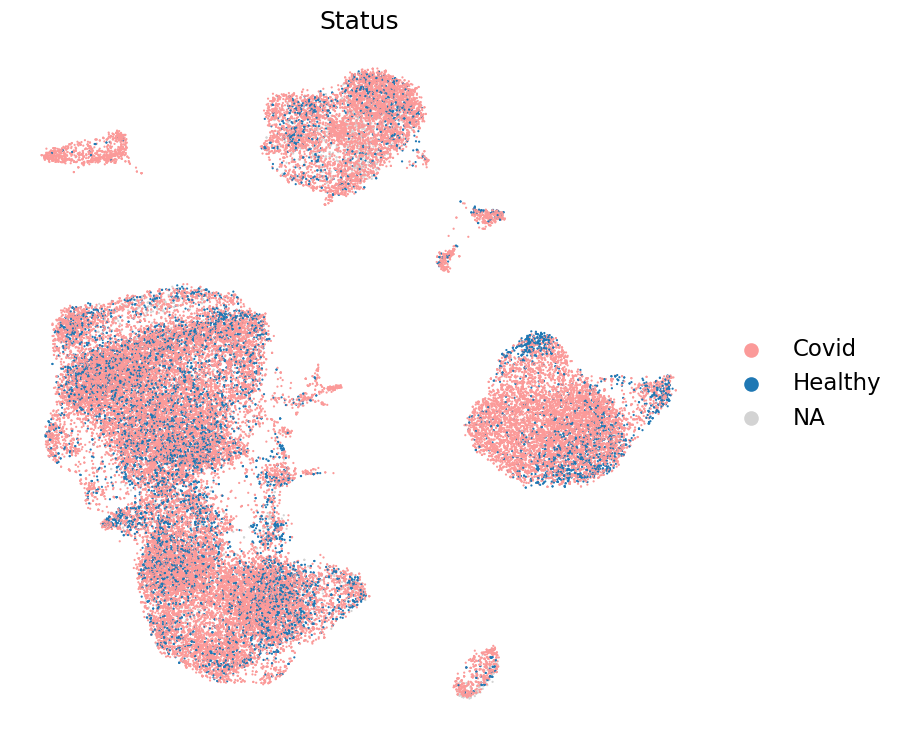

/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


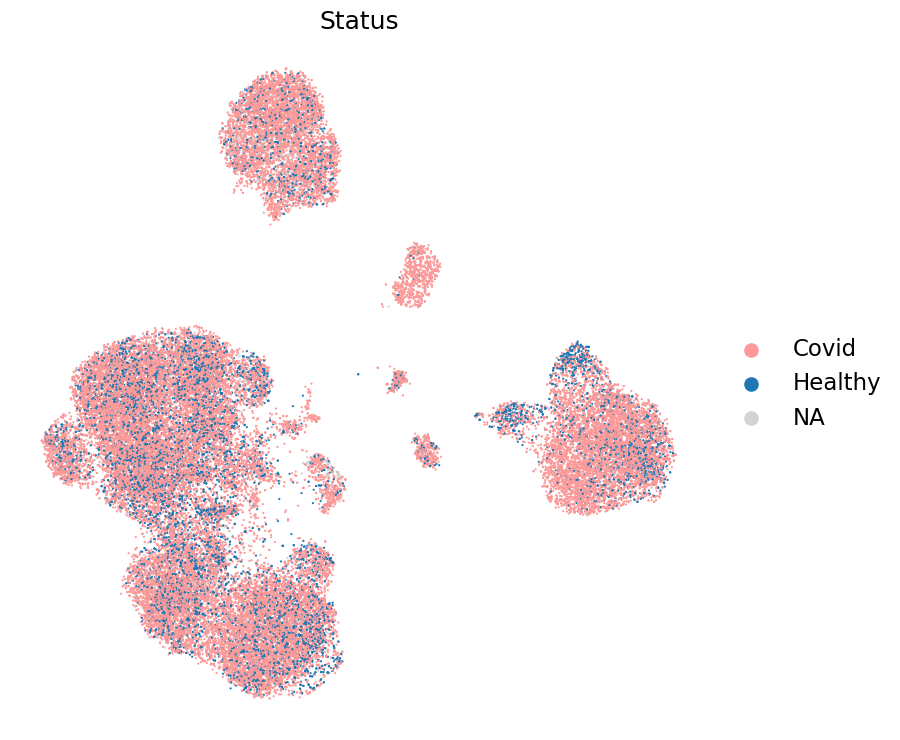

In [24]:
covid_palette = {'Covid':'#fb9a99', "Healthy":'#1f78b4', 'LPS':'#fdbf6f', 'Non_covid':'#fdbf6f'}

with rc_context({'figure.figsize':[9,9]}):
    sc.pl.umap(adata[np.random.choice(adata.obs_names, adata.n_obs)], color=['Status'], 
               legend_loc='right margin', frameon=False, groups=['Covid', 'Healthy'],
               size=10, palette=covid_palette,
              save='PAC_covid_status.png');
    sc.pl.umap(adata_c[np.random.choice(adata_c.obs_names, adata_c.n_obs)], color=['Status'], 
               legend_loc='right margin', frameon=False, groups=['Covid', 'Healthy'],
               size=10, palette=covid_palette,
              save='PC_covid_status.png');


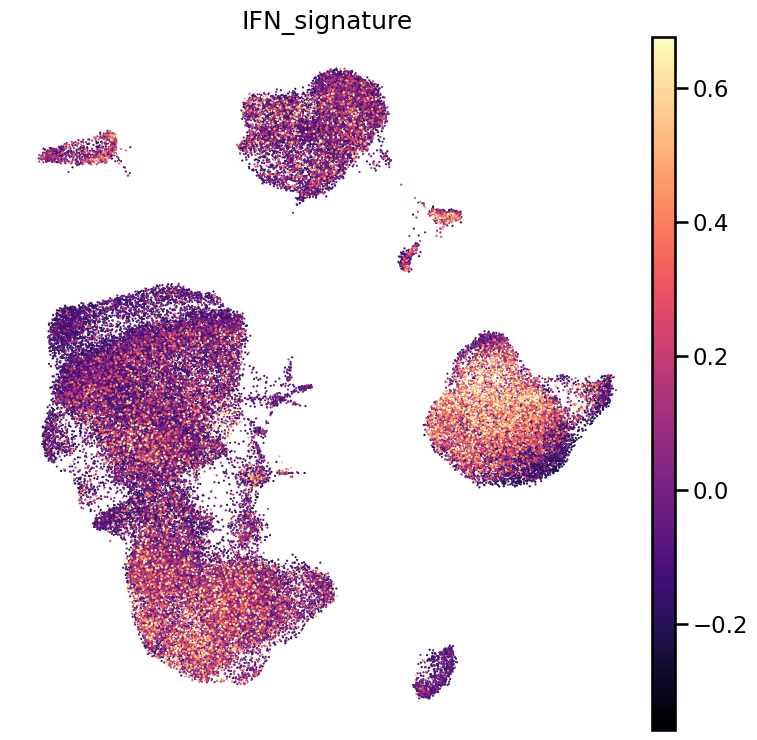

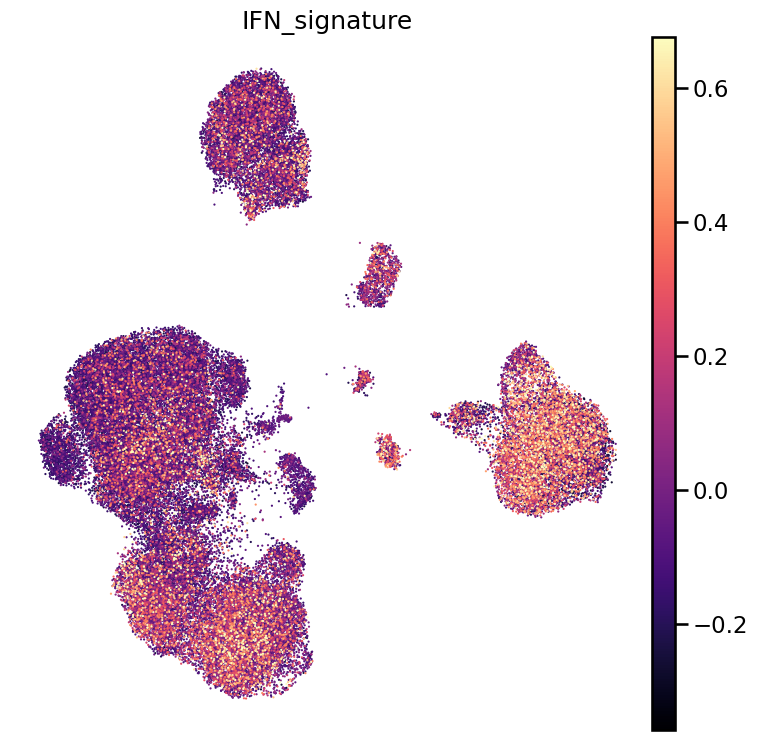

In [25]:
covid_palette = {'Covid':'#fb9a99', "Healthy":'#1f78b4', 'LPS':'#fdbf6f'}
with rc_context({'figure.figsize':[9,9]}):
    sc.pl.umap(adata, color=['IFN_signature'], 
               legend_loc='right margin', frameon=False, 
               size=10, cmap = 'magma', vmax=np.quantile(adata.obs['IFN_signature'], 0.99),
              save='PAC_IFN_status.png');
    sc.pl.umap(adata_c, color=['IFN_signature'], 
               legend_loc='right margin', frameon=False, 
               size=10, cmap = 'magma', vmax=np.quantile(adata.obs['IFN_signature'], 0.99),
              save='PC_IFN_status.png');


In [19]:
print(f"# donors Atlas: {adata_atlas.obs.donor_id.unique().shape[0]}")
print(f"# donors COVID: {adata[adata.obs['Status'] == 'Covid'].obs.donor_id.unique().shape[0]}")
print(f"# donors ctrl: {adata[adata.obs['Status'] == 'Healthy'].obs.donor_id.unique().shape[0]}")

print(f"# studies Atlas: {adata_atlas.obs.dataset_id.unique().shape[0]}")

# donors Atlas: 1219
# donors COVID: 90
# donors ctrl: 23
# studies Atlas: 12


## Plot IFN state recovery

In [20]:
milopy.utils.annotate_nhoods(adata, 'author_cell_type_broad')
milopy.utils.annotate_nhoods(adata_c, 'author_cell_type_broad')

In [21]:
nhood_adata = adata.uns['nhood_adata'].copy()
nhood_adata_c = adata_c.uns['nhood_adata'].copy()

pl_cell_types = nhood_adata.obs['nhood_annotation'].value_counts().index
pl_cell_types = pl_cell_types[pl_cell_types != 'nan']

df1 = nhood_adata.obs[['nhood_IFN_signature', 'logFC', "SpatialFDR", 'nhood_annotation']]
df1['design'] = 'ACR'
df2 = nhood_adata_c.obs[['nhood_IFN_signature', 'logFC', "SpatialFDR", 'nhood_annotation']]
df2['design'] = 'CR'
pl_df = pd.concat([df1,df2])

/tmp/ipykernel_255/3704143388.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['design'] = 'ACR'
/tmp/ipykernel_255/3704143388.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['design'] = 'CR'


In [450]:
%%R -i pl_df
head(pl_df)

  nhood_IFN_signature      logFC  SpatialFDR nhood_annotation design
1         -0.00220008 -0.2194488 0.773792012          NK_16hi    ACR
2         -0.06581493 -0.5853851 0.271597767            CD8_T    ACR
3         -0.07545920 -0.2437837 0.751638382           B_cell    ACR
4         -0.06753626  0.2168581 0.777359813            CD4_T    ACR
5         -0.14077664 -0.2466057 0.766543201            CD4_T    ACR
6         -0.02367600 -1.4926319 0.005747825            CD4_T    ACR


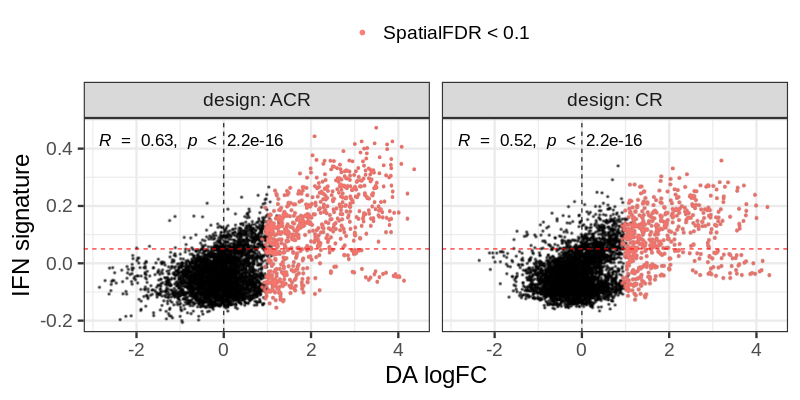

In [451]:
%%R -w 800 -h 400 -i figdir
pl_df %>%
    group_by(nhood_annotation, design) %>%
    ggplot(aes(x=logFC, y=nhood_IFN_signature)) +
    rasterise(geom_point(size=0.2, alpha=0.7)) +
    rasterise(geom_point(data = . %>% filter(SpatialFDR < 0.1 & logFC > 0), aes(color='SpatialFDR < 0.1'), size=0.5, alpha=0.9)) +
    facet_wrap(design~., labeller='label_both') +
    guides(color=guide_legend(title='', override.aes = list(size=2))) +
    theme_bw(base_size=24) +
    geom_vline(xintercept=0, linetype=2) +
    geom_hline(yintercept=0.05, linetype='dashed', color='red') +
    xlab("DA logFC") + ylab("IFN signature") +
    theme(legend.position='top') +
    ggpubr::stat_cor(size=6) +
    ggsave(paste0(figdir, 'IFNVSlogFC_all_ggplot.png'), width=12, height=7) +
    ggsave(paste0(figdir, 'IFNVSlogFC_all_ggplot.pdf'), width=12, height=7)

In [34]:
%%R
install.packages('cocor')
library(cocor)

* installing *source* package ‘cocor’ ...
** package ‘cocor’ successfully unpacked and MD5 sums checked
** using staged installation
** R
** data
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** testing if installed package can be loaded from temporary location
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (cocor)


In [35]:
%%R
cocor_res <- cocor(formula = ~ logFC + nhood_IFN_signature | logFC + nhood_IFN_signature, 
      data = split(pl_df, pl_df$design))
cocor_res


  Results of a comparison of two correlations based on independent groups

Comparison between r1.jk (logFC, nhood_IFN_signature) = 0.6346 and r2.hm (logFC, nhood_IFN_signature) = 0.5241
Difference: r1.jk - r2.hm = 0.1104
Data: ACR: j = logFC, k = nhood_IFN_signature; CR: h = logFC, m = nhood_IFN_signature
Group sizes: n1 = 4789, n2 = 4894
Null hypothesis: r1.jk is equal to r2.hm
Alternative hypothesis: r1.jk is not equal to r2.hm (two-sided)
Alpha: 0.05

fisher1925: Fisher's z (1925)
  z = 8.2137, p-value = 0.0000
  Null hypothesis rejected

zou2007: Zou's (2007) confidence interval
  95% confidence interval for r1.jk - r2.hm: 0.0840 0.1369
  Null hypothesis rejected (Interval does not include 0)



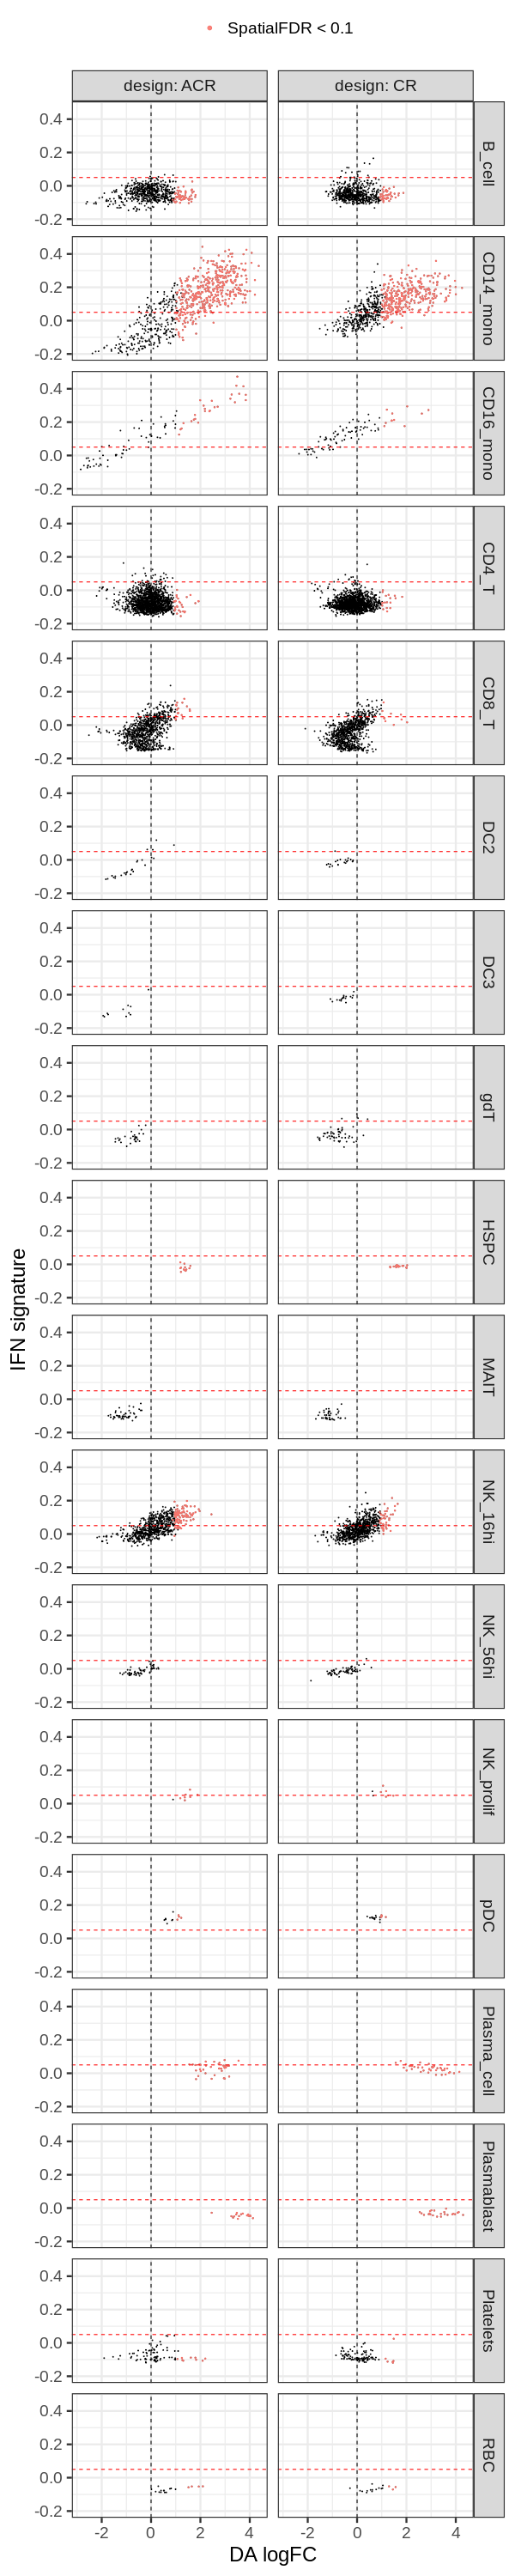

In [36]:
%%R -w 600 -h 3000
pl_df %>%
# group_by(nhood_annotation, design) %>%
# mutate(n_DA = sum(logFC > 1))  %>%
# ungroup() %>%
# filter(n_DA > 5) %>%
ggplot(aes(x=logFC, y=nhood_IFN_signature)) +
geom_point(size=0.3, alpha=0.9) +
geom_point(data = . %>% filter(SpatialFDR < 0.1 & logFC > 0), aes(color='SpatialFDR < 0.1'), size=0.5, alpha=0.9) +
facet_grid(nhood_annotation~design, labeller=labeller(design=label_both)) +
guides(color=guide_legend(title='', override.aes = list(size=2))) +
theme_bw(base_size=24) +
geom_vline(xintercept=0, linetype=2) +
geom_hline(yintercept=0.05, linetype='dashed', color='red') +
xlab("DA logFC") + ylab("IFN signature") +
theme(legend.position='top') +
ggsave(paste0(figdir, 'IFNVSlogFC_cts_ggplot.png'), width=8, height=32) +
ggsave(paste0(figdir, 'IFNVSlogFC_cts_ggplot.pdf'), width=8, height=32)

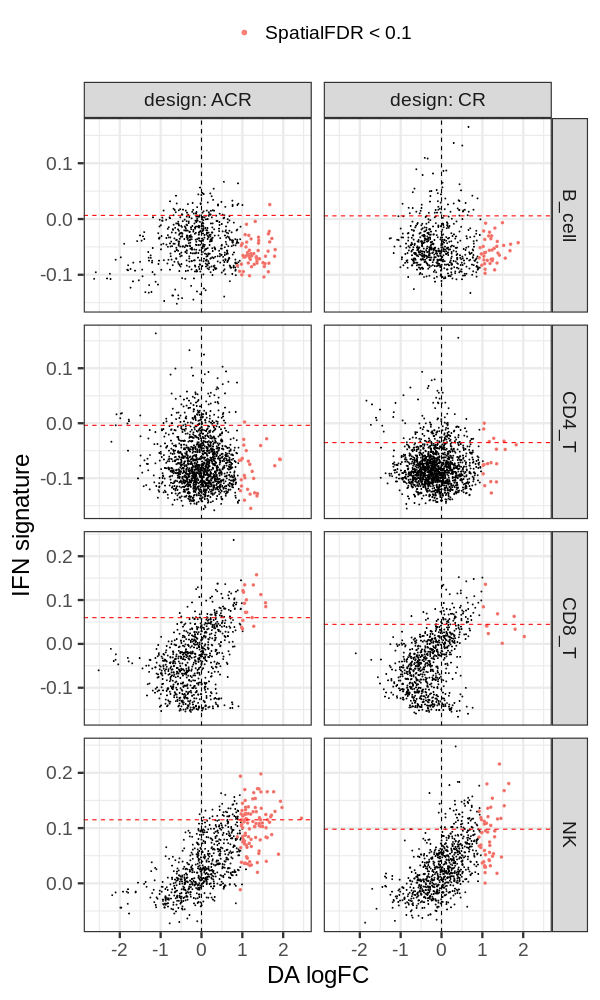

In [452]:
%%R -w 600 -h 1000 -o pl_df
pl_df <- pl_df %>%
    mutate(nhood_annotation = ifelse(str_detect(nhood_annotation, 'NK'), 'NK', nhood_annotation)) %>%
    filter(nhood_annotation %in% c('B_cell', 'NK', 'CD4_T', 'CD8_T')) %>%
    group_by(nhood_annotation, design) %>%
    mutate(thresh_quant = quantile(nhood_IFN_signature, 0.90)) %>%
    mutate(is_IFN_activates = nhood_IFN_signature > thresh_quant)

pl_df %>%
ggplot(aes(x=logFC, y=nhood_IFN_signature)) +
geom_point(size=0.3, alpha=0.9) +
geom_point(data = . %>% filter(SpatialFDR < 0.1 & logFC > 0), aes(color='SpatialFDR < 0.1'), size=1, alpha=0.9) +
facet_grid(nhood_annotation~design, labeller=labeller(design=label_both), scales='free_y') +
guides(color=guide_legend(title='', override.aes = list(size=2))) +
theme_bw(base_size=24) +
geom_vline(xintercept=0, linetype=2) +
geom_hline(aes(yintercept=thresh_quant), linetype='dashed', color='red') +
xlab("DA logFC") + ylab("IFN signature") +
theme(legend.position='top') +
# ggpubr::stat_cor() +
ggsave(paste0(figdir, 'scatter_lymphocytes.pdf'))        
        

In [453]:
pl_df

nhood_IFN_signature     logFC  SpatialFDR nhood_annotation design  \
1               -0.002200 -0.219449    0.773792               NK    ACR   
2               -0.065815 -0.585385    0.271598            CD8_T    ACR   
3               -0.075459 -0.243784    0.751638           B_cell    ACR   
4               -0.067536  0.216858    0.777360            CD4_T    ACR   
5               -0.140777 -0.246606    0.766543            CD4_T    ACR   
...                   ...       ...         ...              ...    ...   
7546            -0.036400 -0.023078    0.974201               NK     CR   
7547            -0.009925 -0.521871    0.378867               NK     CR   
7548             0.063029  0.075590    0.925040               NK     CR   
7549            -0.015759  0.002599    0.987697            CD8_T     CR   
7550             0.066253  0.391962    0.524801               NK     CR   

      thresh_quant  is_IFN_activates  
1         0.115053             False  
2         0.059770             False  
3         0.006503             False  
4        -0.003809             False  
5        -0.003809             False  
...            ...               ...  
7546      0.097975             False  
7547      0.097975             False  
7548      0.097975             False  
7549      0.044643             False  
7550      0.097975             False  

[7550 rows x 7 columns]

In [467]:
from oor_benchmark.metrics import auprc

auprc_df = pd.DataFrame()
for design in ['CR', "ACR"]:
    for ct in pl_df.nhood_annotation.unique():
        nh_df = pl_df[(pl_df['design'] == design) & (pl_df.nhood_annotation == ct)]
        nh_df['OOR_state_group'] = nh_df['is_IFN_activates'].copy()
        nh_df['OOR_score'] = nh_df['logFC'].copy()
        auprc_df_ct = auprc.auprc(nh_df, bootstrap_iterations=1000, bootstrap_seed=42, return_curve=True)
        auprc_df_ct['design'] = design
        auprc_df_ct['thresh'] = nh_df['is_IFN_activates'].sum()/nhood_adata_c.n_obs
        auprc_df_ct['nhood_annotation'] = ct
        auprc_df = pd.concat([auprc_df, auprc_df_ct])

/tmp/ipykernel_14100/772801376.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nh_df['OOR_state_group'] = nh_df['is_IFN_activates'].copy()
/tmp/ipykernel_14100/772801376.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nh_df['OOR_score'] = nh_df['logFC'].copy()


Running bootstrap with 1000 iterations


/tmp/ipykernel_14100/772801376.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nh_df['OOR_state_group'] = nh_df['is_IFN_activates'].copy()
/tmp/ipykernel_14100/772801376.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nh_df['OOR_score'] = nh_df['logFC'].copy()


Running bootstrap with 1000 iterations


/tmp/ipykernel_14100/772801376.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nh_df['OOR_state_group'] = nh_df['is_IFN_activates'].copy()
/tmp/ipykernel_14100/772801376.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nh_df['OOR_score'] = nh_df['logFC'].copy()


Running bootstrap with 1000 iterations


/tmp/ipykernel_14100/772801376.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nh_df['OOR_state_group'] = nh_df['is_IFN_activates'].copy()
/tmp/ipykernel_14100/772801376.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nh_df['OOR_score'] = nh_df['logFC'].copy()


Running bootstrap with 1000 iterations


/tmp/ipykernel_14100/772801376.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nh_df['OOR_state_group'] = nh_df['is_IFN_activates'].copy()
/tmp/ipykernel_14100/772801376.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nh_df['OOR_score'] = nh_df['logFC'].copy()


Running bootstrap with 1000 iterations


/tmp/ipykernel_14100/772801376.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nh_df['OOR_state_group'] = nh_df['is_IFN_activates'].copy()
/tmp/ipykernel_14100/772801376.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nh_df['OOR_score'] = nh_df['logFC'].copy()


Running bootstrap with 1000 iterations


/tmp/ipykernel_14100/772801376.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nh_df['OOR_state_group'] = nh_df['is_IFN_activates'].copy()
/tmp/ipykernel_14100/772801376.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nh_df['OOR_score'] = nh_df['logFC'].copy()


Running bootstrap with 1000 iterations


/tmp/ipykernel_14100/772801376.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nh_df['OOR_state_group'] = nh_df['is_IFN_activates'].copy()
/tmp/ipykernel_14100/772801376.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nh_df['OOR_score'] = nh_df['logFC'].copy()


Running bootstrap with 1000 iterations


In [468]:
auprc_df

Recall  Precision     AUPRC  no_skill_thresh  CI_lower  CI_upper design  \
0        1.0   0.100830  0.357773         0.100830  0.279722  0.451700     CR   
1        1.0   0.100950  0.357773         0.100830  0.279722  0.451700     CR   
2        1.0   0.101070  0.357773         0.100830  0.279722  0.451700     CR   
3        1.0   0.101190  0.357773         0.100830  0.279722  0.451700     CR   
4        1.0   0.101311  0.357773         0.100830  0.279722  0.451700     CR   
...      ...        ...       ...              ...       ...       ...    ...   
1514     0.0   0.000000  0.086781         0.100132  0.079043  0.097903    ACR   
1515     0.0   0.000000  0.086781         0.100132  0.079043  0.097903    ACR   
1516     0.0   0.000000  0.086781         0.100132  0.079043  0.097903    ACR   
1517     0.0   0.000000  0.086781         0.100132  0.079043  0.097903    ACR   
1518     0.0   1.000000  0.086781         0.100132  0.079043  0.097903    ACR   

        thresh nhood_annotation  
0     0.017368               NK  
1     0.017368               NK  
2     0.017368               NK  
3     0.017368               NK  
4     0.017368               NK  
...        ...              ...  
1514  0.031058            CD4_T  
1515  0.031058            CD4_T  
1516  0.031058            CD4_T  
1517  0.031058            CD4_T  
1518  0.031058            CD4_T  

[7558 rows x 9 columns]

In [473]:
df = auprc_df[['AUPRC', 'design','thresh', 'nhood_annotation', 'CI_lower', 'CI_upper']].drop_duplicates()

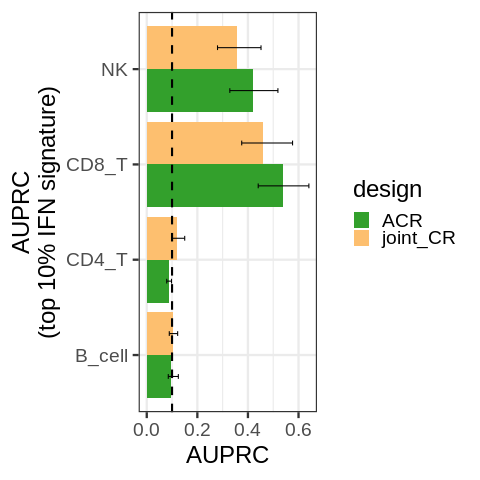

In [472]:
%%R -i df
df %>%
mutate(design = ifelse(design == 'CR', 'joint_CR', design)) %>%
ggplot(aes(AUPRC, nhood_annotation, fill=design)) +
geom_col(position='dodge') +
geom_errorbarh(position=position_dodge(width=0.9), aes(xmin=CI_lower,xmax=CI_upper), height=0.1) +
theme_bw(base_size=24) +
scale_fill_manual(values=design_palette) +
ylab('Nhood annotation') + ylab("AUPRC\n(top 10% IFN signature)") +
geom_vline(xintercept=0.1, linetype=2, size=1) +
ggsave(paste0(figdir, 'AUPRC_lymphocytes.pdf'))

### Check IFN-low positives

In [374]:
order_cts_acr = nhood_adata.obs.groupby('nhood_annotation').mean()['nhood_IFN_signature'].sort_values().index
order_cts_cr = nhood_adata_c.obs.groupby('nhood_annotation').mean()['nhood_IFN_signature'].sort_values().index

In [375]:
mki67_id = adata.var[adata.var_names == 'MKI67']['gene_id'].astype('str')[0]
adata_c.obs['MKI67_expression'] = adata_c[:, mki67_id].X.toarray()
milopy.utils.annotate_nhoods_continuous(adata_c, 'MKI67_expression')

In [376]:
adata.obs['MKI67_expression'] = adata[:, 'MKI67'].X.toarray()
milopy.utils.annotate_nhoods_continuous(adata, 'MKI67_expression')

In [377]:
nhood_acr_df = adata.uns['nhood_adata'].obs.copy()
nhood_acr_df['design'] = 'ACR'
nhood_cr_df = adata_c.uns['nhood_adata'].obs.copy()
nhood_cr_df['design'] = 'CR'
nhood_df = pd.concat([nhood_acr_df, nhood_cr_df])

In [378]:
nhood_df

index_cell  kth_distance  \
0     10_1038_s41591_021_01329_2-S12_GACTGCGTCCTTTCGG-1      0.882193   
1     10_1038_s41591_021_01329_2-S11_CGGTTAATCGGATGGA-1      0.713938   
2     10_1038_s41591_021_01329_2-S12_CTGTGCTAGCTCCTCT-1      0.898555   
3     10_1038_s41591_021_01329_2-S11_CTTCTCTGTACTTAGC-1      0.768485   
4     10_1038_s41591_021_01329_2-S12_CGGACACTCAGCTTAG-1      0.629925   
...                                                 ...           ...   
4889  10_1038_s41591_021_01329_2-CATCGGGCATGCATGT-ne...      1.173680   
4890  10_1038_s41591_021_01329_2-GTGTTAGCACATCCGG-ne...      1.457626   
4891  10_1038_s41591_021_01329_2-GCATACAAGGGCTTCC-ne...      1.229262   
4892  10_1038_s41591_021_01329_2-ATTTCTGCATGAAGTA-ne...      1.218616   
4893  10_1038_s41591_021_01329_2-TGGCCAGCAAACTGTC-ne...      1.160242   

     nhood_annotation  nhood_annotation_frac     logFC    logCPM         F  \
0             NK_16hi               0.982558 -0.219449  8.829422  0.360067   
1               CD8_T               0.781513 -0.585385  9.046490  2.885917   
2              B_cell               0.951613 -0.243784  8.903499  0.430566   
3               CD4_T               0.962963  0.216858  8.894203  0.353893   
4               CD4_T               0.972826 -0.246606  8.872489  0.377497   
...               ...                    ...       ...       ...       ...   
4889          NK_16hi               0.651515 -0.023078  8.947198  0.004396   
4890          NK_16hi               0.398649 -0.521871  8.777230  2.102723   
4891          NK_16hi               0.978022  0.075590  8.894154  0.044539   
4892            CD8_T               0.851852  0.002599  9.001678  0.000607   
4893          NK_16hi               0.950413  0.391962  9.072827  1.274053   

        PValue       FDR  SpatialFDR  nhood_IFN_signature  \
0     0.549098  0.763097    0.773792            -0.002200   
1     0.090797  0.254977    0.271598            -0.065815   
2     0.512410  0.740150    0.751638            -0.075459   
3     0.552540  0.766531    0.777360            -0.067536   
4     0.539593  0.755809    0.766543            -0.140777   
...        ...       ...         ...                  ...   
4889  0.947182  0.974349    0.974201            -0.036400   
4890  0.148141  0.376940    0.378867            -0.009925   
4891  0.833006  0.925577    0.925040             0.063029   
4892  0.980369  0.987837    0.987697            -0.015759   
4893  0.259961  0.523313    0.524801             0.066253   

      nhood_MKI67_expression design  Nhood_size  
0                   0.000000    ACR         NaN  
1                   0.000000    ACR         NaN  
2                   0.000000    ACR         NaN  
3                   0.001256    ACR         NaN  
4                   0.003699    ACR         NaN  
...                      ...    ...         ...  
4889                0.002844     CR       198.0  
4890                0.000000     CR       148.0  
4891                0.000000     CR       182.0  
4892                0.000000     CR       216.0  
4893                0.029416     CR       242.0  

[9683 rows x 14 columns]

In [379]:
# nhood_df = nhood_df.drop('nhood_groups', 1)

In [380]:
%%R -i nhood_df
unique(nhood_df$design)

[1] "ACR" "CR" 


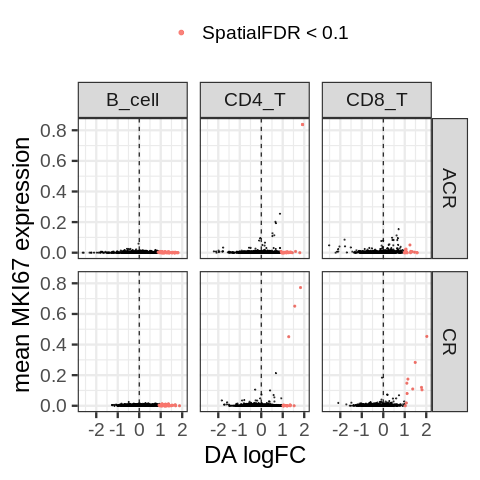

In [384]:
%%R 
nhood_df %>%
filter(nhood_annotation %in% c("CD4_T", "CD8_T", 'B_cell')) %>%
# filter(design == 'CR') %>%
ggplot(aes(logFC, nhood_MKI67_expression)) +
    geom_point(size=0.4, alpha=0.7) +
    geom_point(data = . %>% filter(SpatialFDR < 0.1 & logFC > 0), aes(color='SpatialFDR < 0.1'), size=0.8, alpha=0.9) +
    facet_grid(design~nhood_annotation) +
    guides(color=guide_legend(title='', override.aes = list(size=2))) +
    theme_bw(base_size=24) +
    geom_vline(xintercept=0, linetype=2) +
    xlab("DA logFC") + ylab("mean MKI67 expression") +
    theme(legend.position='top') +
    ggsave(paste0(figdir, 'CR_MKI67VSlogFC_all_ggplot.png'), width=12, height=8) +
    ggsave(paste0(figdir, 'CR_MKI67VSlogFC_all_ggplot.pdf'), width=12, height=8)

In [35]:
milopy.utils.annotate_nhoods(adata, 'author_cell_type')
milopy.utils.annotate_nhoods(adata_c, 'author_cell_type')

In [65]:
nhood_df_acr = adata.uns['nhood_adata'].obs.copy()
nhood_df_cr = adata_c.uns['nhood_adata'].obs.copy()
nhood_df_acr['design'] = "ACR"
nhood_df_cr['design'] = "CR"
nh_df = pd.concat([nhood_df_cr, nhood_df_acr])

In [66]:
%%R -i nh_df
head(nh_df)

                                         index_cell kth_distance
1 10_1038_s41591_021_01329_2-S12_CTCTAATAGTTTCCTT-1     1.223490
2 10_1038_s41591_021_01329_2-S12_CTGTGCTAGCTCCTCT-1     1.339044
3 10_1038_s41591_021_01329_2-S12_AACTGGTGTCACTTCC-1     1.307936
4 10_1038_s41591_021_01329_2-S11_ACGGAGACACCGAAAG-1     1.812499
5 10_1038_s41591_021_01329_2-S11_CACAGGCCATCGATTG-1     1.273504
6 10_1038_s41591_021_01329_2-S12_CCGTACTTCTAACGGT-1     1.117893
  nhood_annotation nhood_annotation_frac      logFC   logCPM         F
1          NK_16hi             0.9572192  0.5616516 8.906660 2.2352000
2          B_naive             0.5000000 -0.9989021 8.875385 6.6130863
3         CD4.IL22             0.4000000 -0.2893993 8.836750 0.5294987
4           CD4.CM             0.4435484  0.6117078 8.706196 2.1022317
5        CD8.Naive             0.9197531 -0.7178039 8.844436 3.5545718
6           CD4.CM             0.4825871 -0.2771340 8.979543 0.5137140
      PValue        FDR SpatialFDR nhood_IFN_sig

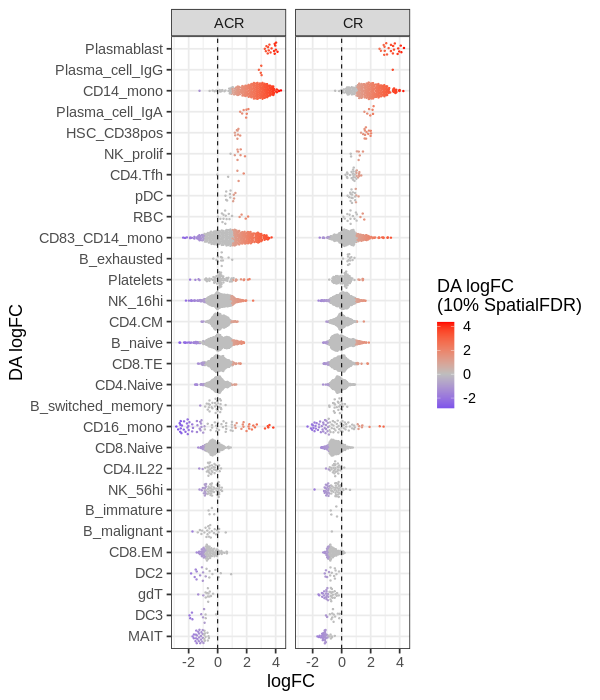

In [67]:
%%R -h 700 -w 600
nh_df %>%
filter(nhood_annotation_frac > 0.5) %>%
mutate(signif=ifelse(SpatialFDR < 0.1, logFC, 0)) %>%
group_by(nhood_annotation)%>%
mutate(mean_lfc_val = ifelse(!is.na(signif), logFC, 0)) %>%
mutate(mean_lfc = mean(mean_lfc_val)) %>%
ungroup() %>%
arrange(mean_lfc) %>%
mutate(nhood_annotation=factor(nhood_annotation, levels=unique(nhood_annotation))) %>%
ggplot(aes(nhood_annotation, logFC, color=signif)) + 
    ggbeeswarm::geom_quasirandom(size=0.5) +
        coord_flip() +
        facet_wrap(design~.) +
        scale_color_gradient2(high='red', mid='grey', low='blue', name='DA logFC\n(10% SpatialFDR)') +
        theme_bw(base_size=18) +
        geom_hline(yintercept=0, linetype=2) +
        xlab('Nhood annotation\n(original fine annotation)') + xlab('DA logFC') +
        ggsave(paste0(figdir, 'beeswarm_fine_anno.png'), width=10, height=12) +
        ggsave(paste0(figdir, 'beeswarm_fine_anno.pdf'), width=10, height=12)

In [82]:
%%R -h 700 -w 600 -i nh_df
p1 <- nh_df %>%
filter(nhood_annotation_frac > 0.5) %>%
# filter(logFC > 0 & SpatialFDR < 0.1) %>%
filter(design == 'CR') %>%
mutate(signif=ifelse(SpatialFDR < 0.1, logFC, 0)) %>%
group_by(nhood_annotation)%>%
mutate(mean_lfc_val = ifelse(!is.na(signif), logFC, 0)) %>%
mutate(mean_lfc = max(mean_lfc_val)) %>%
ungroup() %>%
arrange(mean_lfc) %>%
mutate(nhood_annotation=factor(nhood_annotation, levels=unique(nhood_annotation))) %>%
    mutate(signif = ifelse(logFC > 4, 4, ifelse(signif < -2.1, -2.1, signif))) %>%
ggplot(aes(nhood_annotation, logFC, color=signif)) + 
    ggbeeswarm::geom_quasirandom(size=0.5) +
        coord_flip() +
        facet_wrap(design~.) +
        scale_color_gradient2(high='red', mid='grey', low='blue', name='DA logFC\n(10% SpatialFDR)') +
        theme_bw(base_size=18) +
        geom_hline(yintercept=0, linetype=2) +
        xlab('Nhood annotation\n(original fine annotation)') + xlab('DA logFC')

In [83]:
%%R -h 700 -w 600 -i nh_df
p2 <- nh_df %>%
    filter(nhood_annotation_frac > 0.5) %>%
    # filter(logFC > 0 & SpatialFDR < 0.1) %>%
    filter(design == 'ACR') %>%
    mutate(signif=ifelse(SpatialFDR < 0.1, logFC, 0)) %>%
    group_by(nhood_annotation)%>%
    mutate(mean_lfc_val = ifelse(!is.na(signif), logFC, 0)) %>%
    mutate(mean_lfc = max(mean_lfc_val)) %>%
    ungroup() %>%
    arrange(mean_lfc) %>%
    mutate(nhood_annotation=factor(nhood_annotation, levels=unique(nhood_annotation))) %>%
    mutate(signif = ifelse(signif > 4, 4, ifelse(signif < -2.1, -2.1, signif))) %>%
    ggplot(aes(nhood_annotation, logFC, color=signif)) + 
        ggbeeswarm::geom_quasirandom(size=0.5) +
            coord_flip() +
            facet_wrap(design~.) +
            scale_color_gradient2(high='red', mid='grey', low='blue', name='DA logFC\n(10% SpatialFDR)') +
            theme_bw(base_size=18) +
            geom_hline(yintercept=0, linetype=2) +
            xlab('Nhood annotation\n(original fine annotation)') + xlab('DA logFC')

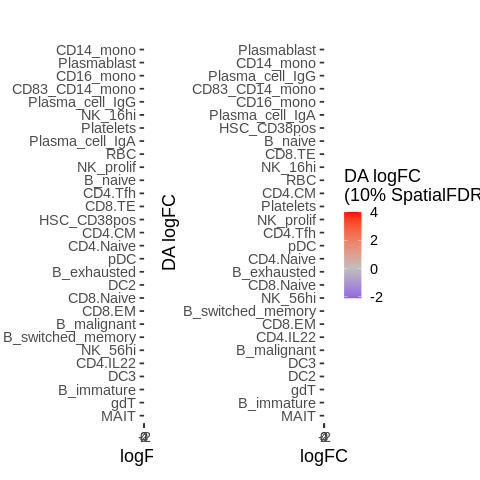

In [86]:
%%R

(p2 + p1) + 
plot_layout(guides='collect') +
ggsave(paste0(figdir, 'beeswarm_fine_anno.png'), width=14, height=12) +
ggsave(paste0(figdir, 'beeswarm_fine_anno.pdf'), width=14, height=12)

### Precision-recall analysis

In [22]:
# scipy.stats.pearsonr(nhood_adata_c.obs['logFC'], nhood_adata_c.obs['nhood_IFN_signature'])
# scipy.stats.pearsonr(nhood_adata.obs['logFC'], nhood_adata.obs['nhood_IFN_signature'])
from sklearn.metrics import precision_recall_curve, auc

min_sign = 0.05
nhood_adata.obs['is_IFN_activated'] = nhood_adata.obs['nhood_IFN_signature'] > min_sign
nhood_adata_c.obs['is_IFN_activated'] = nhood_adata_c.obs['nhood_IFN_signature'] > min_sign

pr, rec, _ = precision_recall_curve(nhood_adata_c.obs['is_IFN_activated'], nhood_adata_c.obs['logFC'])
auprc_df_c = pd.DataFrame(np.vstack([pr, rec]).T, columns=['Precision', 'Recall'])
auprc_df_c['AUPRC'] = auc(rec, pr)
auprc_df_c['design'] = 'PC'
auprc_df_c['thresh'] = nhood_adata_c.obs['is_IFN_activated'].sum()/nhood_adata_c.n_obs

pr, rec, _ = precision_recall_curve(nhood_adata.obs['is_IFN_activated'], nhood_adata.obs['logFC'])
auprc_df = pd.DataFrame(np.vstack([pr, rec]).T, columns=['Precision', 'Recall'])
auprc_df['AUPRC'] = auc(rec, pr)
auprc_df['design'] = 'PAC'
auprc_df['thresh'] = nhood_adata.obs['is_IFN_activated'].sum()/nhood_adata.n_obs 

auprc_df = pd.concat([auprc_df, auprc_df_c])

In [23]:
%%R -i auprc_df
head(auprc_df)

  Precision Recall     AUPRC design    thresh
1 0.2033828      1 0.6693779    PAC 0.2033828
2 0.2034252      1 0.6693779    PAC 0.2033828
3 0.2034677      1 0.6693779    PAC 0.2033828
4 0.2035102      1 0.6693779    PAC 0.2033828
5 0.2035528      1 0.6693779    PAC 0.2033828
6 0.2035953      1 0.6693779    PAC 0.2033828


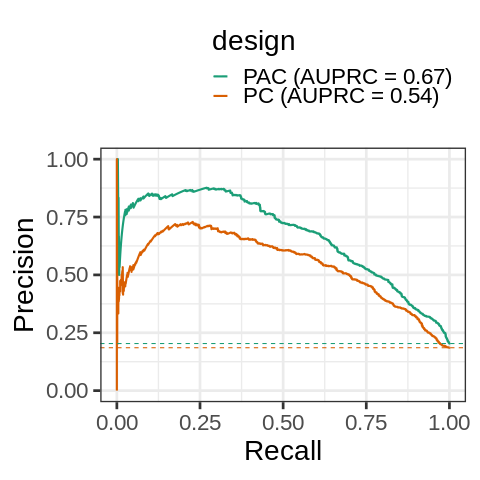

In [24]:
%%R
auprc_df %>%
mutate(design = str_c(design, ' (AUPRC = ', round(AUPRC, 2), ')')) %>%
ggplot(aes(Recall, Precision, group=design, color=design)) +
geom_line(size=1) +
geom_hline(linetype=2, aes(yintercept=thresh, color=design)) +
scale_color_brewer(palette='Dark2') +
guides(color=guide_legend(ncol=1, title.position='top')) +
theme_bw(base_size=28) +
theme(legend.position='top', legend.justification='right') +
ggsave(paste0(figdir, 'PR_curves_IFN.png'), width=6, height=8) +
ggsave(paste0(figdir, 'PR_curves_IFN.pdf'), width=6, height=8)

In [25]:
milopy.utils.annotate_nhoods(adata, 'author_cell_type')
milopy.utils.annotate_nhoods(adata_c, 'author_cell_type')

## Compare with _de novo_ integration including disease cases

Prepare ACR design design object (de novo integration) 

In [27]:
data_dir = '/lustre/scratch126/cellgen/team205/ed6/PBMC_COVID/'
adata_p = sc.read_h5ad(data_dir + 'PBMC_COVID.subsample500cells.design._PAC.h5ad')

## Add dataset specific obs
new_obs = stephenson_obs.loc[[x.split('10_1038_s41591_021_01329_2-')[-1] for x in adata_p.obs_names]]
new_obs.index = adata_p.obs_names
adata_p.obs = pd.concat([new_obs.loc[:,~new_obs.columns.isin(adata_p.obs.columns)], adata_p.obs], 1)


/tmp/ipykernel_255/672278616.py:7: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  adata_p.obs = pd.concat([new_obs.loc[:,~new_obs.columns.isin(adata_p.obs.columns)], adata_p.obs], 1)


Prepare CR design design object (de novo integration) 

In [40]:
data_dir = '/lustre/scratch126/cellgen/team205/ed6/PBMC_COVID/'
adata_pc = sc.read_h5ad(data_dir + 'PBMC_COVID.subsample500cells.design.query_P_refC.h5ad')

## Add dataset specific obs
new_obs = stephenson_obs.loc[[x.split('10_1038_s41591_021_01329_2-')[-1] for x in adata_pc.obs_names]]
new_obs.index = adata_pc.obs_names
adata_pc.obs = pd.concat([new_obs.loc[:,~new_obs.columns.isin(adata_pc.obs.columns)], adata_pc.obs], 1)


/tmp/ipykernel_255/522052441.py:7: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  adata_pc.obs = pd.concat([new_obs.loc[:,~new_obs.columns.isin(adata_pc.obs.columns)], adata_pc.obs], 1)


Run differential analysis

In [41]:
run_milo(adata_p, 'P', 'C', sample_col='sample_id', annotation_col='cell_type', design='~Site+is_query')
run_milo(adata_pc, 'P', 'C', sample_col='sample_id', annotation_col='cell_type', design='~Site+is_query')

/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/scipy/sparse/_base.py:665: RuntimeWarning: invalid value encountered in divide
  return np.true_divide(self.todense(), other)
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/scipy/sparse/_base.py:665: RuntimeWarning: invalid value encountered in divide
  return np.true_divide(self.todense(), other)


In [42]:
adata_p.obs['author_cell_type_broad'] = [anno_labels_dict[x] for x in adata_p.obs['author_cell_type']]
adata_pc.obs['author_cell_type_broad'] = [anno_labels_dict[x] for x in adata_pc.obs['author_cell_type']]

In [43]:
milopy.utils.annotate_nhoods(adata_p, 'author_cell_type_broad')
adata_p.obs['IFN_signature'] = adata.obs.loc[adata_p.obs_names, 'IFN_signature']
milopy.utils.annotate_nhoods_continuous(adata_p, "IFN_signature")
nhood_adata_p = adata_p.uns['nhood_adata'].copy()

milopy.utils.annotate_nhoods(adata_pc, 'author_cell_type_broad')
adata_pc.obs['IFN_signature'] = adata.obs.loc[adata_pc.obs_names, 'IFN_signature']
milopy.utils.annotate_nhoods_continuous(adata_pc, "IFN_signature")
nhood_adata_pc = adata_pc.uns['nhood_adata'].copy()

In [60]:
nhood_adata = adata.uns['nhood_adata'].copy()
nhood_adata_c = adata_c.uns['nhood_adata'].copy()

In [71]:
from oor_benchmark.metrics import auprc

min_sign = 0.05
nhood_adata.obs['is_IFN_activated'] = nhood_adata.obs['nhood_IFN_signature'] > min_sign
nhood_adata_c.obs['is_IFN_activated'] = nhood_adata_c.obs['nhood_IFN_signature'] > min_sign
nhood_adata_p.obs['is_IFN_activated'] = nhood_adata_p.obs['nhood_IFN_signature'] > min_sign
nhood_adata_pc.obs['is_IFN_activated'] = nhood_adata_pc.obs['nhood_IFN_signature'] > min_sign

design_dict = {'ACR - scArches scVI':nhood_adata, 'ACR - scVI': nhood_adata_p, "CR - scVI": nhood_adata_c, 'CR - scArches scVI': nhood_adata_pc}

auprc_df = pd.DataFrame()
for d, nhood_ad in design_dict.items():
    res_df = nhood_ad.obs.copy()
    res_df['OOR_state_group'] = res_df['is_IFN_activated'].copy()
    res_df['OOR_score'] = res_df['logFC'].copy()
    auprc_df_s = auprc.auprc(res_df, bootstrap_iterations=1000, return_curve=True)
    auprc_df_s['design'] = d
    auprc_df = pd.concat([auprc_df, auprc_df_s])

Running bootstrap with 1000 iterations
Running bootstrap with 1000 iterations
Running bootstrap with 1000 iterations
Running bootstrap with 1000 iterations


In [74]:
auprc_df

Recall  Precision     AUPRC  no_skill_thresh  CI_lower  CI_upper  \
0        1.0   0.203383  0.669378         0.203383  0.637999  0.696643   
1        1.0   0.203425  0.669378         0.203383  0.637999  0.696643   
2        1.0   0.203468  0.669378         0.203383  0.637999  0.696643   
3        1.0   0.203510  0.669378         0.203383  0.637999  0.696643   
4        1.0   0.203553  0.669378         0.203383  0.637999  0.696643   
...      ...        ...       ...              ...       ...       ...   
4842     0.0   0.000000  0.439725         0.193768  0.416238  0.466349   
4843     0.0   0.000000  0.439725         0.193768  0.416238  0.466349   
4844     0.0   0.000000  0.439725         0.193768  0.416238  0.466349   
4845     0.0   0.000000  0.439725         0.193768  0.416238  0.466349   
4846     0.0   1.000000  0.439725         0.193768  0.416238  0.466349   

                   design  
0     ACR - scArches scVI  
1     ACR - scArches scVI  
2     ACR - scArches scVI  
3     ACR - scArches scVI  
4     ACR - scArches scVI  
...                   ...  
4842   CR - scArches scVI  
4843   CR - scArches scVI  
4844   CR - scArches scVI  
4845   CR - scArches scVI  
4846   CR - scArches scVI  

[19425 rows x 7 columns]

In [75]:
%%R -i auprc_df
head(auprc_df)

  Recall Precision     AUPRC no_skill_thresh  CI_lower  CI_upper
1      1 0.2033828 0.6693779       0.2033828 0.6379986 0.6966426
2      1 0.2034252 0.6693779       0.2033828 0.6379986 0.6966426
3      1 0.2034677 0.6693779       0.2033828 0.6379986 0.6966426
4      1 0.2035102 0.6693779       0.2033828 0.6379986 0.6966426
5      1 0.2035528 0.6693779       0.2033828 0.6379986 0.6966426
6      1 0.2035953 0.6693779       0.2033828 0.6379986 0.6966426
               design
1 ACR - scArches scVI
2 ACR - scArches scVI
3 ACR - scArches scVI
4 ACR - scArches scVI
5 ACR - scArches scVI
6 ACR - scArches scVI


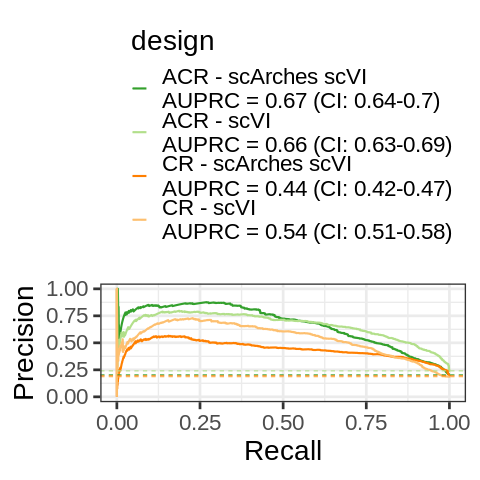

In [77]:
%%R
design_pal <- RColorBrewer::brewer.pal("Paired", n=10)[c(4,3,8,7)]

auprc_df %>%
    mutate(design = str_c(design, ' \nAUPRC = ', round(AUPRC, 2), ' (CI: ', round(CI_lower, 2), '-', round(CI_upper, 2), ')')) %>%
    ggplot(aes(Recall, Precision, group=design, color=design)) +
    geom_line(size=1) +
    geom_hline(linetype=2, aes(yintercept=no_skill_thresh, color=design)) +
    scale_color_manual(values=design_pal) +
    guides(color=guide_legend(ncol=1, title.position='top')) +
    theme_bw(base_size=28) +
    theme(legend.position='top', legend.justification='right') +
    ggsave(paste0(figdir, 'PR_curves_IFN.png'), width=6, height=10) +
    ggsave(paste0(figdir, 'PR_curves_IFN.pdf'), width=6, height=10)

## Save outputs

In [23]:
milopy.utils.write_milo_adata(adata, filepath=data_dir + 'PBMC_COVID.subsample500cells.design.query_PC_refA.post_milo.h5ad')

In [21]:
# milopy.utils.write_milo_adata(adata_c, filepath=data_dir + 'PBMC_COVID.subsample500cells.design.query_P_refC.post_milo.h5ad')

In [87]:
milopy.utils.write_milo_adata(adata_c, filepath=data_dir + 'PBMC_COVID.subsample500cells.design._PC.post_milo.h5ad')

## Pathological subtypes analysis - check IFN-low enriched states

In [12]:
data_dir = '/lustre/scratch126/cellgen/team205/ed6/PBMC_COVID/'
# adata = milopy.utils.read_milo_adata(data_dir + 'PBMC_COVID.subsample500cells.design.query_PC_refA.post_milo.h5ad')

adata = sc.read_h5ad(data_dir + 'PBMC_COVID.subsample500cells.design.query_PC_refA.post_milo.h5ad')
nhood_adata = sc.read_h5ad(data_dir + 'PBMC_COVID.subsample500cells.design.query_PC_refA.post_milo.nhood_adata.h5ad')

adata.uns['nhood_adata'] = nhood_adata.copy()

/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [7]:
anno_labels = adata.obs['author_cell_type'].unique()
anno_groups = {}
anno_groups['B_cell'] = [x for x in adata.obs['author_cell_type'].unique() if x.startswith('B_')]
anno_groups['HSPC'] = [x for x in adata.obs['author_cell_type'].unique() if x.startswith('HSC_')]
anno_groups['CD14_mono'] =[x for x in adata.obs['author_cell_type'].unique() if 'CD14_mono' in x]
anno_groups['CD16_mono'] =[x for x in adata.obs['author_cell_type'].unique() if 'CD16_mono' in x]
anno_groups['CD4_T'] =[x for x in adata.obs['author_cell_type'].unique() if x.startswith("CD4.")]
anno_groups['CD8_T'] =[x for x in adata.obs['author_cell_type'].unique() if x.startswith("CD8.")]
anno_groups['ILC'] =[x for x in adata.obs['author_cell_type'].unique() if x.startswith("ILC")]
anno_groups['Plasma_cell'] =[x for x in adata.obs['author_cell_type'].unique() if x.startswith("Plasma_cell")]

for x in anno_labels: 
    if x not in sum(anno_groups.values(), []):
        anno_groups[x] = [x]

anno_labels_dict = {x:k for k,v in anno_groups.items() for x in v}
adata.obs['author_cell_type_broad'] = [anno_labels_dict[x] for x in adata.obs['author_cell_type']]
milopy.utils.annotate_nhoods(adata, anno_col='author_cell_type_broad')

In [8]:
milo_res = adata.uns['nhood_adata'].obs.copy()

In [10]:
mono_res=milo_res[milo_res.nhood_annotation.isin(['CD14_mono', 'CD16_mono'])]

In [20]:
%%R -i mono_res
head(mono_res)

                                          index_cell kth_distance
7  10_1038_s41591_021_01329_2-S11_CTACATTGTCATCGGC-1    0.8488339
9  10_1038_s41591_021_01329_2-S11_CGTCACTGTCATACTG-1    0.7458368
16 10_1038_s41591_021_01329_2-S11_GACTAACCACTTACGA-1    0.8635404
21 10_1038_s41591_021_01329_2-S11_TGGGCGTTCAGTCAGT-1    0.7818075
23 10_1038_s41591_021_01329_2-S11_GTCTCGTAGTTTCCTT-1    0.9215596
25 10_1038_s41591_021_01329_2-S11_AGTGAGGAGGCTCAGA-1    1.1544625
   nhood_annotation nhood_annotation_frac       logFC   logCPM            F
7         CD14_mono             0.9772727 -0.78879948 8.859451  3.969117777
9         CD14_mono             0.9802955  0.49986790 8.967559  1.254272107
16        CD14_mono             1.0000000  0.03823584 8.730108  0.008553883
21        CD14_mono             0.8720379  1.26915138 9.003519  6.943061569
23        CD14_mono             0.9800000  2.82206506 8.790340 28.341172501
25        CD14_mono             0.9935898 -0.68602556 8.801006  3.122999346
      

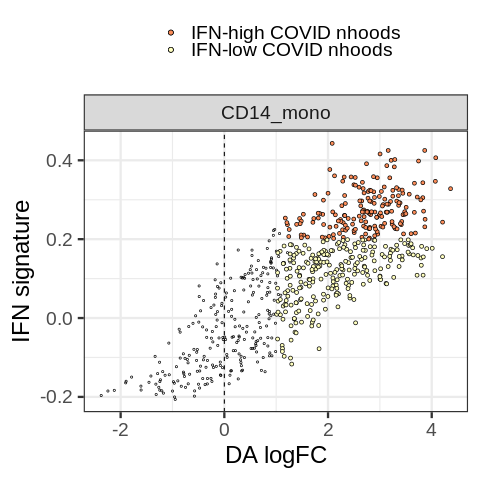

In [21]:
%%R
mono_res %>%
    filter(nhood_annotation == 'CD14_mono') %>%
    ggplot(aes(logFC, nhood_IFN_signature)) +
    geom_point(size=0.7, shape=21) +
    geom_point(data=. %>% filter(SpatialFDR < 0.1 & logFC > 1 & nhood_IFN_signature > 0.2), 
               shape=21,
               aes(fill='IFN-high COVID nhoods')) +
    geom_point(data=. %>% filter(SpatialFDR < 0.1 & logFC > 1 & nhood_IFN_signature < 0.2), 
               shape=21,
               aes(fill='IFN-low COVID nhoods')) +
    facet_wrap(nhood_annotation~.) +
    guides(fill=guide_legend(title='', override.aes = list(size=2), ncol=1)) +
    theme_bw(base_size=24) +
    scale_fill_brewer(palette='Spectral', name='') +
    geom_vline(xintercept=0, linetype=2) +
#     geom_hline(yintercept=0, linetype='dashed', color='red') +
    xlab("DA logFC") + ylab("IFN signature") +
    theme(legend.position='top') +
    ggsave(paste0(figdir, 'groups_CD14_monos.png'), height=7, width=7) +
    ggsave(paste0(figdir, 'groups_CD14_monos.pdf'), height=7, width=7)
    

In [162]:
import diff2atlas

def run_glmGamPoi_DE(pbulk_adata, 
                     design = '~ Site + nhood_groups',
                    ref_level = 'in_nhoods_other',
                    contrast = 'nhood_groupsin_nhoods_critical',
                     n_hvgs = 5000):
    '''
    Run R code for DE analysis with glmGamPoi
    
    Params:
    ------
    - pbulk_adata: anndata object with pseudobulked data
    
    '''
    
    ## Define R function
    glmgampoi_str = f'''
        library(SingleCellExperiment)
        library(glmGamPoi)
        library(scran)
        library(scater)

        run_de <- function(args){{
            pbulk_sdata_X <- args[[1]]
            pbulk_sdata_obs <- args[[2]]
            pbulk_sdata_var <- args[[3]]
            n_hvgs <- args[[4]]

            sce <- SingleCellExperiment(assays = list(counts = t(pbulk_sdata_X)), colData = pbulk_sdata_obs)
            sce <- logNormCounts(sce)

            ## Feature selection w scran (just on test cell types)
            dec <- modelGeneVar(sce)
            hvgs <- getTopHVGs(dec, n = n_hvgs)
            subset_sce <- sce[hvgs,]

            ## Fit
            fit <- glm_gp(subset_sce, design = {design}, reference_level = '{ref_level}')

            ## Test 
            de_res <- test_de(fit, contrast = '{contrast}')    
            de_res[,'gene_name'] <- pbulk_sdata_var[hvgs,]['gene_name']
            return(de_res)
        }}'''
    
    import rpy2.robjects.pandas2ri
    import rpy2.robjects.numpy2ri
    from rpy2.robjects.packages import STAP
    
    ## Get anndata components
    pbulk_sdata_X = pbulk_adata.X.toarray().copy()
    pbulk_sdata_obs = pbulk_adata.obs.copy()
    pbulk_sdata_var = pbulk_adata.var.copy()
    
    r_pkg = STAP(glmgampoi_str, "r_pkg")
    # this was needed for the code to run on jhub
    # if you have a different version of rpy2 you may not need these two lines
    rpy2.robjects.pandas2ri.activate()
    rpy2.robjects.numpy2ri.activate()
    
    # PASS OBJECTS INTO FUNCTION
    args = [pbulk_sdata_X, pbulk_sdata_obs, pbulk_sdata_var, n_hvgs]
    de_res_df = r_pkg.run_de(args).to_csvfile('./DE_results.csv')
    de_res_df = pd.read_csv('./DE_results.csv', index_col=0)
    de_res_df.index = de_res_df['gene_name']
    de_res_df.drop('name', 1, inplace=True)
    os.remove('./DE_results.csv')
    return(de_res_df)

def find_nhood_group_markers(
    adata, 
    test_group: str,
    ctrl_group: str,
    confounders_obs = None,
    nhood_group_obs: str = 'nhood_groups',
    min_n_nhoods: int = 3,
    pbulk_use_layer: str = None,
    n_hvgs: int = 5
    ):
    '''
    Find genes differentially expressed between cells in 2 groups of neighbourhoods
    
    Params:
    -------
    - adata: AnnData object storing nhood info in adata.uns['nhood_adata']
    - design: design formula for the test, passed to glmGamPoi
    - test_group: which neighbourhood group is the test group?
    - ctrl_group: which neighbourhood group is the reference group?
    - nhood_group_obs: the column in adata.uns['nhood_adata'] storing the neighbourhood group information
    - min_n_nhoods: cells are assigned to a neighbourhood group only if it belongs to at least min_n_nhoods neighbourhoods in the group
    - pbulk_use_layer: layer storing counts (if None, adata.X is used) 
    - n_hvgs: how many HVGS to use for the DE test (the more you use, the longer it takes)
    
    Returns:
    --------
    pd.DataFrame storing DE test results
    '''

    ## Find cells in nhoods of interest
    groups = adata.uns['nhood_adata'].obs[nhood_group_obs].dropna().unique()
    for g in groups:
        nhoods_oi = adata.uns['nhood_adata'].obs_names[adata.uns['nhood_adata'].obs[nhood_group_obs] == g]
        diff2atlas.utils.get_cells_in_nhoods(adata, nhoods_oi)
        adata.obs[f'in_nhoods_{g}'] = adata.obs['in_nhoods'].copy()

    ## Find most representative group (cell belongs to mostly to neighbourhoods of that group)
    adata.obs['nhood_groups'] = np.nan
    adata.obs['nhood_groups'] = adata.obs[[f'in_nhoods_{g}' for g in groups]].idxmax(1)
    ## Keep only if cell is in at least min_n_nhoods nhoods of the same group
    adata.obs.loc[~(adata.obs[[f'in_nhoods_{g}' for g in groups]] > min_n_nhoods).any(1), 'nhood_groups'] = np.nan 

    ## Make pseudobulk adata for cells if different nhood groups and samples
    sdata = adata[~adata.obs['nhood_groups'].isna()].copy()
    sdata.X = sdata.layers['counts'].copy()
    if confounders_obs is None:
        design = '~ nhood_groups'
        pbulk_sdata = diff2atlas.utils.anndata2pseudobulk(
            sdata, 
            group_by=[adata.uns['nhood_adata'].uns['sample_col'], 'nhood_groups'], 
            min_ncells=1, 
            use_layer=pbulk_use_layer)
    else:
        if isinstance(confounders_obs, str):
            confounder_obs = [confounders_obs]
        design = "~ " + ' + '.join(confounders_obs) + ' + nhood_groups'
        pbulk_sdata = diff2atlas.utils.anndata2pseudobulk(
            sdata, 
            group_by=[nhood_adata.uns['sample_col'], 'nhood_groups'] + confounders_obs, 
            min_ncells=1, 
            use_layer=pbulk_use_layer)
    
    pbulk_sdata.var = adata.var.copy() 
    de_results = run_glmGamPoi_DE(pbulk_sdata, design=design, 
                           ref_level = f'in_nhoods_{ctrl_group}', 
                           contrast = f'nhood_groupsin_nhoods_{test_group}', 
                           n_hvgs=n_hvgs)
    return(de_results)

In [22]:
## Select nhoods of interest
cd14_mono_res = mono_res[mono_res.nhood_annotation == 'CD14_mono']
low_ifn_monos_nhoods = cd14_mono_res.index[(cd14_mono_res.SpatialFDR < 0.1) & (cd14_mono_res.logFC > 0) & (cd14_mono_res.nhood_IFN_signature < 0.2)]
high_ifn_monos_nhoods = cd14_mono_res.index[(cd14_mono_res.SpatialFDR < 0.1) & (cd14_mono_res.logFC > 0) & (cd14_mono_res.nhood_IFN_signature > 0.2)]

In [23]:
other_monos_nhoods = cd14_mono_res.index[~((cd14_mono_res.SpatialFDR < 0.1) & (cd14_mono_res.logFC > 0))]

In [24]:
## Mark nhood groups
nhood_adata = adata.uns['nhood_adata'].copy()
nhood_adata.obs['nhood_groups'] = np.nan
nhood_adata.obs.loc[low_ifn_monos_nhoods, 'nhood_groups'] = 'low_ifn_enr'
nhood_adata.obs.loc[high_ifn_monos_nhoods, 'nhood_groups'] = 'high_ifn_enr'
nhood_adata.obs.loc[other_monos_nhoods, 'nhood_groups'] = 'other_CD14_monos'
adata.uns['nhood_adata'] = nhood_adata.copy()

In [65]:
## Run DE testing
DE_monos_ifn = find_nhood_group_markers(
    adata[adata.obs['author_cell_type'] == 'CD14_mono' ], 
    test_group='low_ifn_enr', 
    ctrl_group='high_ifn_enr', 
    confounders_obs=['Site'],
    n_hvgs = 7500
    )


/nfs/team205/ed6/bin/diff2atlas/diff2atlas/utils.py:19: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['in_nhoods'] = in_nhoods
/tmp/ipykernel_10319/3522525962.py:110: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  adata.obs.loc[~(adata.obs[[f'in_nhoods_{g}' for g in groups]] > min_n_nhoods).any(1), 'nhood_groups'] = np.nan
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():
/tmp/ipykernel_10319/3522525962.py:67: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  de_res_df.drop('name', 1, inplace=True)


In [66]:
DE_monos_ifn

pval      adj_pval  f_statistic  df1         df2       lfc  \
gene_name                                                                       
IFI27      4.855253e-01  7.758508e-01     0.487977    1  233.831244 -0.338966   
IFITM1     1.510698e-02  1.146512e-01     5.992048    1  233.831244 -0.870994   
IFITM3     1.583460e-02  1.175652e-01     5.906960    1  233.831244 -0.612019   
IFI30      1.016861e-19  3.170572e-16    99.280062    1  233.831244 -0.777538   
IFI6       1.570185e-01  4.739434e-01     2.015630    1  233.831244 -0.353517   
...                 ...           ...          ...  ...         ...       ...   
ARMCX6     3.398490e-01  6.691818e-01     0.914735    1  233.831244 -0.239128   
AGAP9      4.289123e-02  2.254707e-01     4.144752    1  233.831244  1.184103   
C12orf65   5.691454e-02  2.672583e-01     3.661205    1  233.831244 -0.942446   
CRELD2     4.794033e-01  7.727975e-01     0.501829    1  233.831244 -0.133901   
EIF4A3     7.207215e-01  8.935227e-01     0.128111    1  233.831244 -0.059521   

          gene_name  
gene_name            
IFI27         IFI27  
IFITM1       IFITM1  
IFITM3       IFITM3  
IFI30         IFI30  
IFI6           IFI6  
...             ...  
ARMCX6       ARMCX6  
AGAP9         AGAP9  
C12orf65   C12orf65  
CRELD2       CRELD2  
EIF4A3       EIF4A3  

[6236 rows x 7 columns]

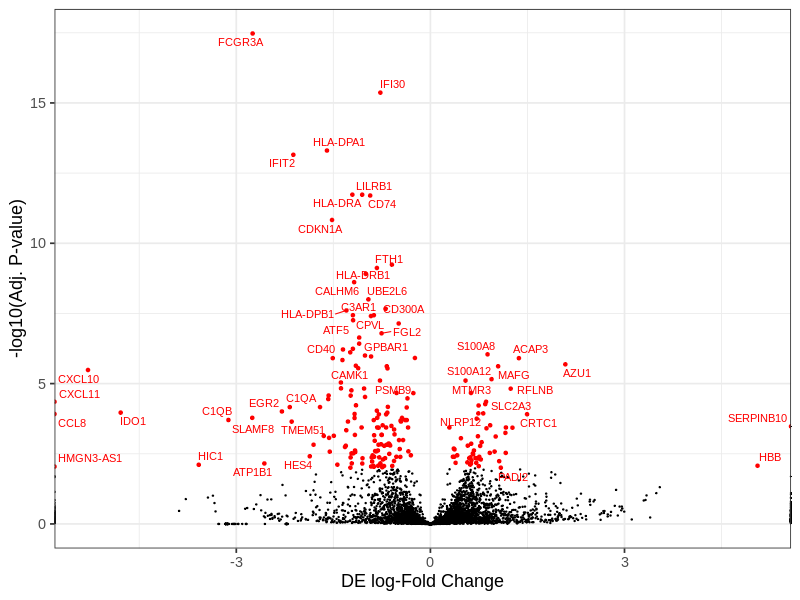

In [176]:
%%R -i DE_monos_ifn -w 800 -h 600 -i figdir
max_lfc = 15
DE_monos_ifn$lfc <- ifelse(abs(DE_monos_ifn$lfc) > max_lfc, sign(DE_monos_ifn$lfc) * Inf, DE_monos_ifn$lfc)
DE_monos_ifn %>%
#     filter(contrast == 'mild_enr-other') %>%
    mutate(signif = adj_pval < 0.01) %>%
    mutate(label = ifelse(signif & (abs(lfc) > 0.75), as.character(gene_name), NA)) %>%
    ggplot(aes(lfc, -log10(adj_pval))) + 
    geom_point(size=0.5) +
    geom_point(data=. %>% filter(signif), color='red') +
    ggrepel::geom_text_repel(aes(label=label), color='red') +
    theme_bw(base_size=18) +
    xlab("DE log-Fold Change") +
    ylab('-log10(Adj. P-value)') +
    ggsave(paste0(figdir, 'volcano_CD14_monos.png'), height=7, width=7) +
    ggsave(paste0(figdir, 'volcano_CD14_monos.pdf'), height=7, width=7) 

In [71]:
data_dir + "CD14_mono.DE_results.csv"

'/lustre/scratch117/cellgen/team205/ed6/PBMC_COVID/CD14_mono.DE_results.csv'

In [164]:
DE_monos_ifn = pd.read_csv('/lustre/scratch126/cellgen/team205/ed6/PBMC_COVID/CD14_mono.DE_results.csv')

In [70]:
## Save for supplementary
DE_monos_ifn.to_csv(data_dir + "CD14_mono.DE_results.csv")

In [27]:
import diff2atlas
def assign_cells_2_nhood_group(
    adata, 
    confounders_obs = None,
    nhood_group_obs: str = 'nhood_groups',
    min_n_nhoods: int = 3,
    pbulk_use_layer: str = None,
    ):
    '''
    
    '''
    ## Find cells in nhoods of interest
    groups = adata.uns['nhood_adata'].obs[nhood_group_obs].dropna().unique()
    for g in groups:
        nhoods_oi = adata.uns['nhood_adata'].obs_names[adata.uns['nhood_adata'].obs[nhood_group_obs] == g]
        diff2atlas.utils.get_cells_in_nhoods(adata, nhoods_oi)
        adata.obs[f'in_nhoods_{g}'] = adata.obs['in_nhoods'].copy()

    ## Find most representative group (cell belongs to mostly to neighbourhoods of that group)
    adata.obs['nhood_groups'] = np.nan
    adata.obs['nhood_groups'] = adata.obs[[f'in_nhoods_{g}' for g in groups]].idxmax(1)
    ## Keep only if cell is in at least min_n_nhoods nhoods of the same group
    adata.obs.loc[~(adata.obs[[f'in_nhoods_{g}' for g in groups]] > min_n_nhoods).any(1), 'nhood_groups'] = np.nan 

In [28]:
assign_cells_2_nhood_group(adata)

In [29]:
groups = adata.uns['nhood_adata'].obs['nhood_groups'].dropna().unique()
min_n_nhoods = 3
adata.obs['nhood_groups'] = np.nan
adata.obs['nhood_groups'] = adata.obs[[f'in_nhoods_{g}' for g in groups]].idxmax(1)
## Keep only if cell is in at least min_n_nhoods nhoods of the same group
adata.obs.loc[~(adata.obs[[f'in_nhoods_{g}' for g in groups]] > min_n_nhoods).any(1), 'nhood_groups'] = np.nan 


In [30]:
plt.rcParams['figure.figsize'] = [10, 10]
# n_cells_sev = adata.obs[['nhood_groups', 'Status_on_day_collection_summary', 'Days_from_onset', 'donor_id']].dropna().value_counts().reset_index()
# n_cells_sev['n_cells'] = n_cells_sev[0]

# n_cells_sev
# n_cells_sev = adata_c.obs[['nhood_groups', 'Status_on_day_collection_summary', 'Days_from_onset', 'donor_id']].dropna().value_counts().reset_index()
# n_cells_sev['n_cells'] = n_cells_sev[0]

# n_cells_sev
n_cells_sev = adata.obs[['nhood_groups', 'Status_on_day_collection_summary', 'donor_id']].dropna()
n_cells_sev['n_cells'] = 1
n_cells_sev = n_cells_sev.groupby(['nhood_groups', 'Status_on_day_collection_summary', 'donor_id']).sum().reset_index()

order_severity = ['Healthy', 'Asymptomatic', 'Mild', "Moderate", "Severe", "Critical"]
# sns.boxplot(data=n_cells_sev, x='Status_on_day_collection_summary', y='n_cells', hue='nhood_groups', order=order_severity)
# sns.stripplot(data=n_cells_sev, x='Status_on_day_collection_summary', y='n_cells', hue='nhood_groups', 
#               color='black', position='dodge',
#               order=order_severity)
# n_cells_sev = n_cells_sev[~n_cells_sev.Days_from_onset.isin(['Healthy', 'LPS', 'Not_known', 'nan'])]

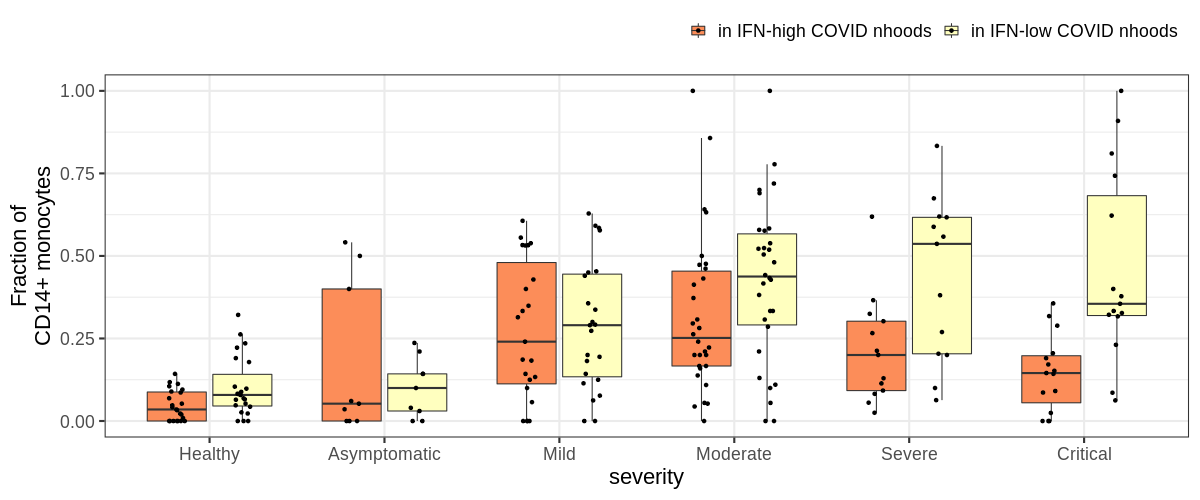

In [307]:
%%R -i order_severity -i n_cells_sev -w 1200 -h 500
n_cells_sev %>%
    filter(Status_on_day_collection_summary %in% order_severity) %>%
    mutate(severity = factor(Status_on_day_collection_summary, levels=order_severity)) %>%
    group_by(donor_id, severity) %>%
    mutate(frac_cells = n_cells/sum(n_cells)) %>%
    ungroup() %>%
    filter(nhood_groups != 'in_nhoods_other_CD14_monos') %>%
    ggplot(aes(severity, frac_cells, fill = nhood_groups)) +
    geom_boxplot(outlier.alpha=0) +
    geom_point(position=position_jitterdodge(jitter.width=0.1)) +
#     facet_wrap(nhood_groups~.) +
#     scale_y_log10() +
    scale_fill_brewer(palette='Spectral', 
                      labels=c('in_nhoods_high_ifn_enr' = 'in IFN-high COVID nhoods', 'in_nhoods_low_ifn_enr' = 'in IFN-low COVID nhoods'),
                      name=''
                     ) +
    ylab('Fraction of\nCD14+ monocytes') +
    theme_bw(base_size=22) +
    theme(legend.position='top', legend.justification=c(1,1)) +
    ggsave(paste0(figdir, 'CD14_monos_severity.png'), height=7, width=10) +
    ggsave(paste0(figdir, 'CD14_monos_severity.pdf'), height=7, width=10) 

Number of donors by severity

In [22]:
adata.obs[['donor_id', 'disease', 'Status_on_day_collection_summary']].drop_duplicates().value_counts('Status_on_day_collection_summary')

Status_on_day_collection_summary
Moderate        30
Healthy         23
Mild            23
Critical        15
Severe          13
Asymptomatic     9
LPS_10hours      3
LPS_90mins       3
dtype: int64

In [311]:
%%R -i order_severity -i n_cells_sev -w 1200 -h 500 -o ttest_res 
ttest_res <- n_cells_sev %>%
    filter(Status_on_day_collection_summary %in% order_severity) %>%
    mutate(severity = factor(Status_on_day_collection_summary, levels=order_severity)) %>%
    group_by(donor_id, severity) %>%
    mutate(frac_cells = n_cells/sum(n_cells)) %>%
    ungroup() %>%
    filter(nhood_groups != 'in_nhoods_other_CD14_monos') %>%
    group_by(nhood_groups, Status_on_day_collection_summary) %>%
    summarise(fracs = list(frac_cells))  %>%
    ungroup() %>%
    pivot_wider(id_cols=nhood_groups, names_from=Status_on_day_collection_summary, values_from=fracs) %>%
        group_by(nhood_groups) %>%
    mutate(pval_vsAsymp = wilcox.test(unlist(Healthy), unlist(Asymptomatic))$p.value, stat_vsAsymp = wilcox.test(unlist(Healthy), unlist(Asymptomatic))$statistic,
          pval_vsMild = wilcox.test(unlist(Healthy), unlist(Mild))$p.value, stat_vsMild = wilcox.test(unlist(Healthy), unlist(Mild))$statistic,
          pval_vsModerate = wilcox.test(unlist(Healthy), unlist(Moderate))$p.value, stat_vsModerate = wilcox.test(unlist(Healthy), unlist(Moderate))$statistic,
          pval_vsCrit = wilcox.test(unlist(Healthy), unlist(Critical))$p.value, stat_vsCrit = wilcox.test(unlist(Healthy), unlist(Critical))$statistic,
          pval_MildvsCrit = wilcox.test(unlist(Moderate), unlist(Critical))$p.value, stat_MildvsCrit = wilcox.test(unlist(Moderate), unlist(Critical))$statistic) %>%
    select( - c(order_severity))

`summarise()` has grouped output by 'nhood_groups'. You can override using the
`.groups` argument.


In [312]:
ttest_res

nhood_groups  pval_vsAsymp  stat_vsAsymp  pval_vsMild  \
1  in_nhoods_high_ifn_enr      0.469303          86.0     0.000148   
2   in_nhoods_low_ifn_enr      1.000000         104.0     0.000474   

   stat_vsMild  pval_vsModerate  stat_vsModerate  pval_vsCrit  stat_vsCrit  \
1         92.5     1.191922e-07             50.0     0.007996         84.0   
2        105.0     2.667588e-06             83.0     0.000017         28.0   

   pval_MildvsCrit  stat_MildvsCrit  
1         0.007498            336.5  
2         1.000000            225.5

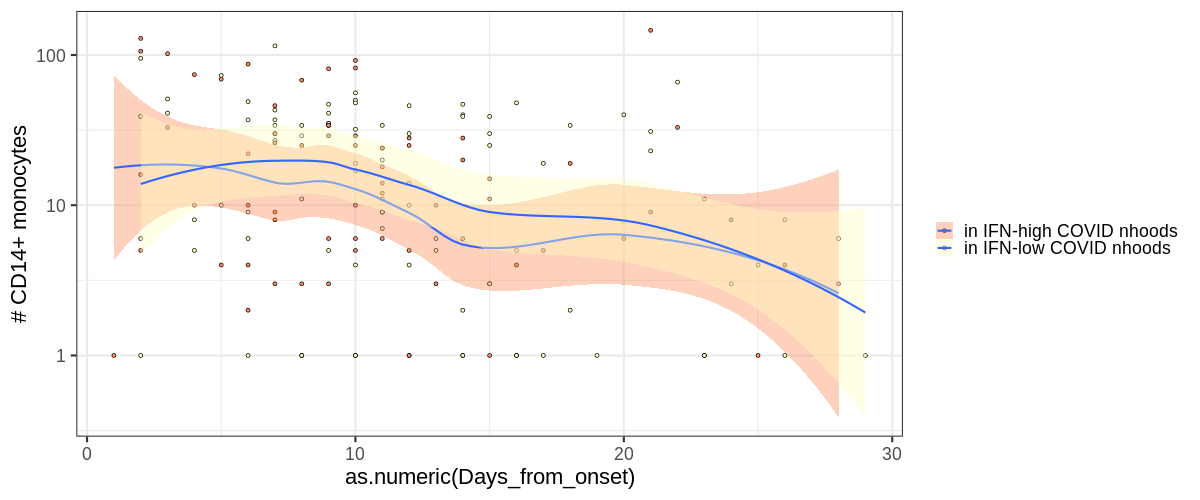

In [134]:
%%R -i order_severity -i n_cells_sev -w 1200 -h 500
n_cells_sev %>%
    filter(nhood_groups != 'in_nhoods_other_CD14_monos') %>%
    filter(Status_on_day_collection_summary %in% order_severity) %>%
    mutate(severity = factor(Status_on_day_collection_summary, levels=order_severity)) %>%
#     filter(Days_from_onset != 'Not_known') %>%
    ggplot(aes(as.numeric(Days_from_onset), n_cells, fill = nhood_groups)) +
#     geom_boxplot(outlier.alpha=0) +
    geom_point(shape=21) +
#     facet_wrap(nhood_groups~.) +
    scale_y_log10() +
    geom_smooth() +
    scale_color_brewer(palette='Spectral', 
                      labels=c('in_nhoods_high_ifn_enr' = 'in IFN-high COVID nhoods', 'in_nhoods_low_ifn_enr' = 'in IFN-low COVID nhoods'),
                      name=''
                     ) +
    scale_fill_brewer(palette='Spectral', 
                      labels=c('in_nhoods_high_ifn_enr' = 'in IFN-high COVID nhoods', 'in_nhoods_low_ifn_enr' = 'in IFN-low COVID nhoods'),
                      name=''
                     ) +
    ylab('# CD14+ monocytes') +
    theme_bw(base_size=22)

In [408]:
DE_monos_ifn[DE_monos_ifn['gene_name'].isin(ifn_signature_genes)]

gene_name          pval      adj_pval  f_statistic  df1         df2  \
4        IFI6  1.570185e-01  4.739434e-01     2.015630    1  233.831244   
7        LY6E  1.865277e-03  2.809629e-02     9.902177    1  233.831244   
8      IFI44L  7.192480e-02  3.063682e-01     3.268089    1  233.831244   
14      ISG15  3.272439e-02  1.907190e-01     4.614834    1  233.831244   
16        MX1  7.636485e-03  7.394583e-02     7.241876    1  233.831244   
45     EPSTI1  3.591714e-04  7.831443e-03    13.115198    1  233.831244   
48      IFIT3  2.330193e-08  2.421847e-06    33.450310    1  233.831244   
66       XAF1  1.009290e-03  1.748893e-02    11.088378    1  233.831244   
89      STAT1  2.039131e-03  2.971033e-02     9.731314    1  233.831244   
110      OAS1  6.130625e-07  3.893265e-05    26.300236    1  233.831244   
113       MX2  2.673240e-03  3.608295e-02     9.214221    1  233.831244   
124    TRIM22  8.507584e-03  7.903333e-02     7.042126    1  233.831244   
125      IRF7  1.260944e-05  4.708530e-04    19.911805    1  233.831244   
126    UBE2L6  1.977854e-12  8.222600e-10    55.265330    1  233.831244   
137     HERC5  4.120896e-08  3.893622e-06    32.186237    1  233.831244   
149     CMPK2  3.405690e-02  1.957821e-01     4.545053    1  233.831244   
158      BST2  7.082912e-04  1.326398e-02    11.778879    1  233.831244   
168     IFI35  8.838245e-05  2.460504e-03    15.921295    1  233.831244   
170      OAS2  3.247217e-03  4.124164e-02     8.844743    1  233.831244   
186    SAMD9L  1.050345e-05  4.007930e-04    20.291473    1  233.831244   
191     PARP9  9.149609e-03  8.305235e-02     6.907968    1  233.831244   
232     SAMD9  1.119369e-07  8.743755e-06    29.988271    1  233.831244   
287    PLSCR1  4.906060e-05  1.529709e-03    17.116634    1  233.831244   
290     SP110  3.183090e-06  1.447755e-04    22.792556    1  233.831244   
533   EIF2AK2  2.505181e-03  3.467744e-02     9.337933    1  233.831244   

          lfc gene_name.1  
4   -0.353517        IFI6  
7   -0.650201        LY6E  
8   -0.523371      IFI44L  
14  -0.506823       ISG15  
16  -0.607943         MX1  
45  -0.734761      EPSTI1  
48  -1.384970       IFIT3  
66  -0.563076        XAF1  
89  -0.514002       STAT1  
110 -0.797110        OAS1  
113 -0.536472         MX2  
124 -0.432215      TRIM22  
125 -0.677578        IRF7  
126 -0.962575      UBE2L6  
137 -1.227057       HERC5  
149 -0.503261       CMPK2  
158 -0.377051        BST2  
168 -0.562462       IFI35  
170 -0.527680        OAS2  
186 -0.865209      SAMD9L  
191 -0.462084       PARP9  
232 -1.015619       SAMD9  
287 -0.528665      PLSCR1  
290 -0.561999       SP110  
533 -0.471353     EIF2AK2

In [411]:
adata.var_names[adata.var_names.str.startswith("S100")]

Index(['S100PBP', 'S100A10', 'S100A11', 'S100A9', 'S100A12', 'S100A8',
       'S100A6', 'S100A5', 'S100A4', 'S100A3', 'S100A2', 'S100A16', 'S100A14',
       'S100A13', 'S100A1', 'S100P', 'S100Z', 'S100B'],
      dtype='object')

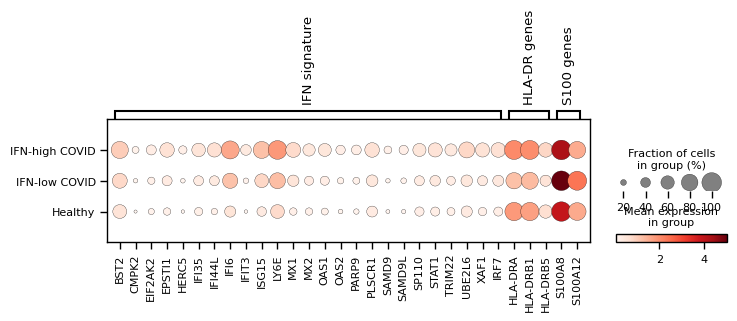

In [437]:
mono_phenotype = {
    'in_nhoods_low_ifn_enr':'IFN-low COVID',
    'in_nhoods_high_ifn_enr':'IFN-high COVID',
    'in_nhoods_other_CD14_monos':'Healthy',
    }

adata.obs['mono_phenotype'] = np.nan
adata.obs.loc[~adata.obs['nhood_groups'].isna(),'mono_phenotype'] = [mono_phenotype[x] for x in adata.obs['nhood_groups'][~adata.obs['nhood_groups'].isna()]]
adata.obs['mono_phenotype'] = adata.obs['mono_phenotype'].astype('category').cat.reorder_categories(['IFN-high COVID', 'IFN-low COVID','Healthy'])
sns.set_context('paper')
sc.pl.dotplot(adata[~adata.obs['nhood_groups'].isna()], {
    'IFN signature':ifn_signature_genes,
    'HLA-DR genes':['HLA-DRA', 'HLA-DRB1', 'HLA-DRB5'], 
    'S100 genes':['S100A8', 'S100A12']}, 
              groupby='mono_phenotype', figsize=[8,1.6], save='monos_markers.pdf')

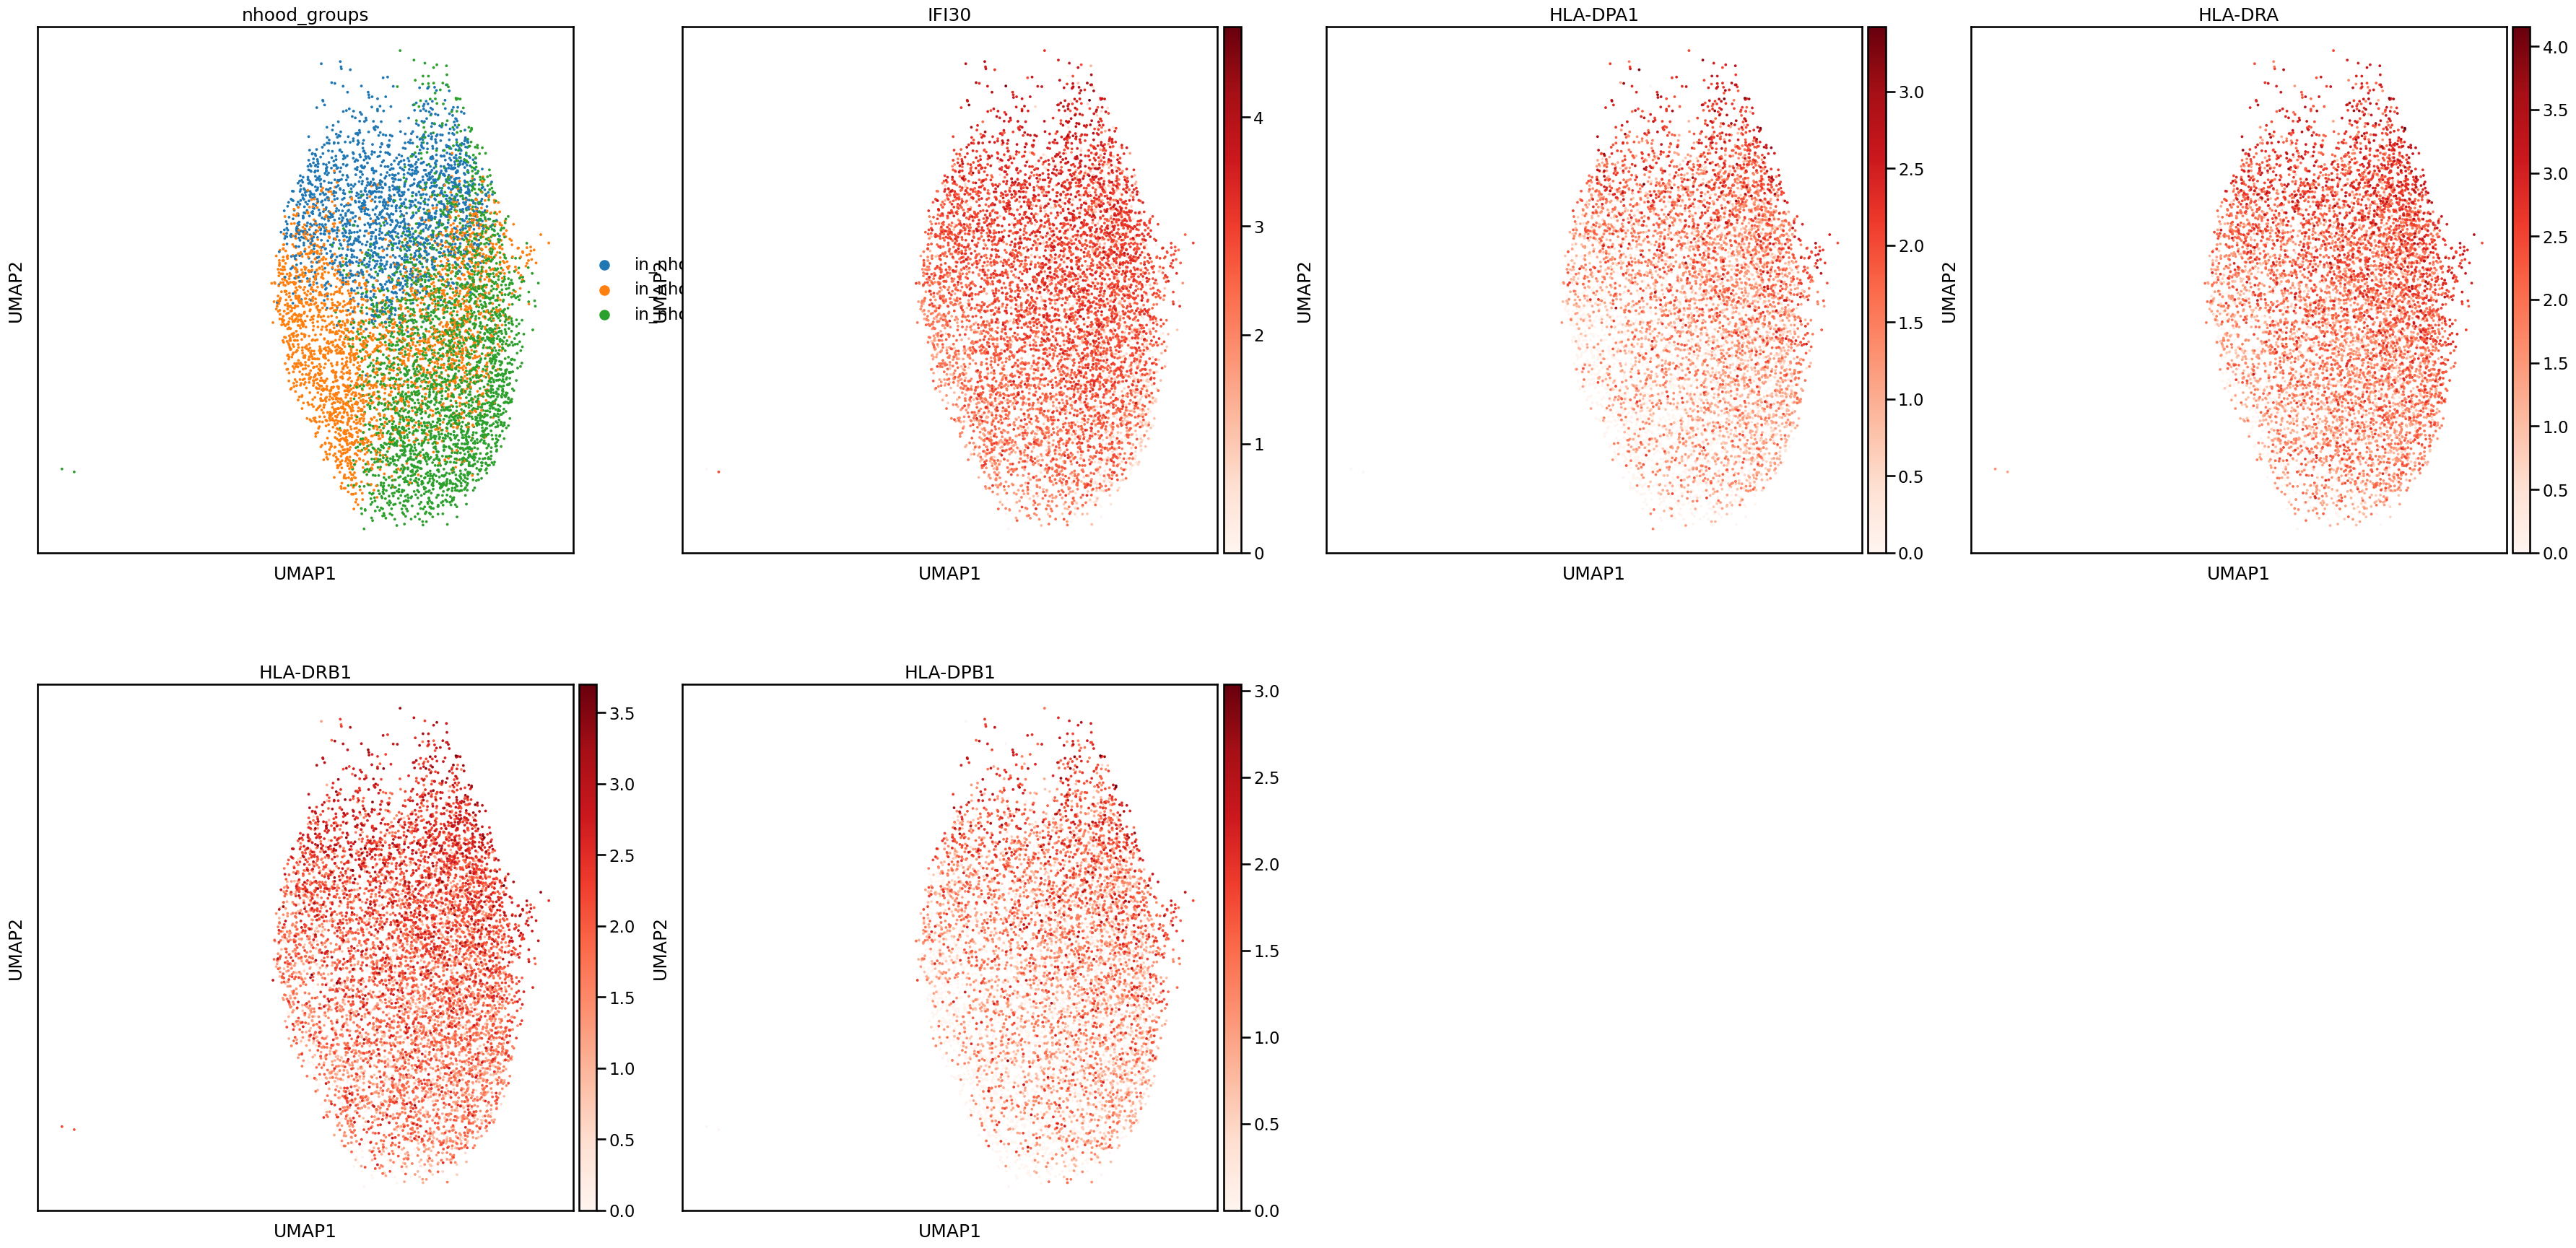

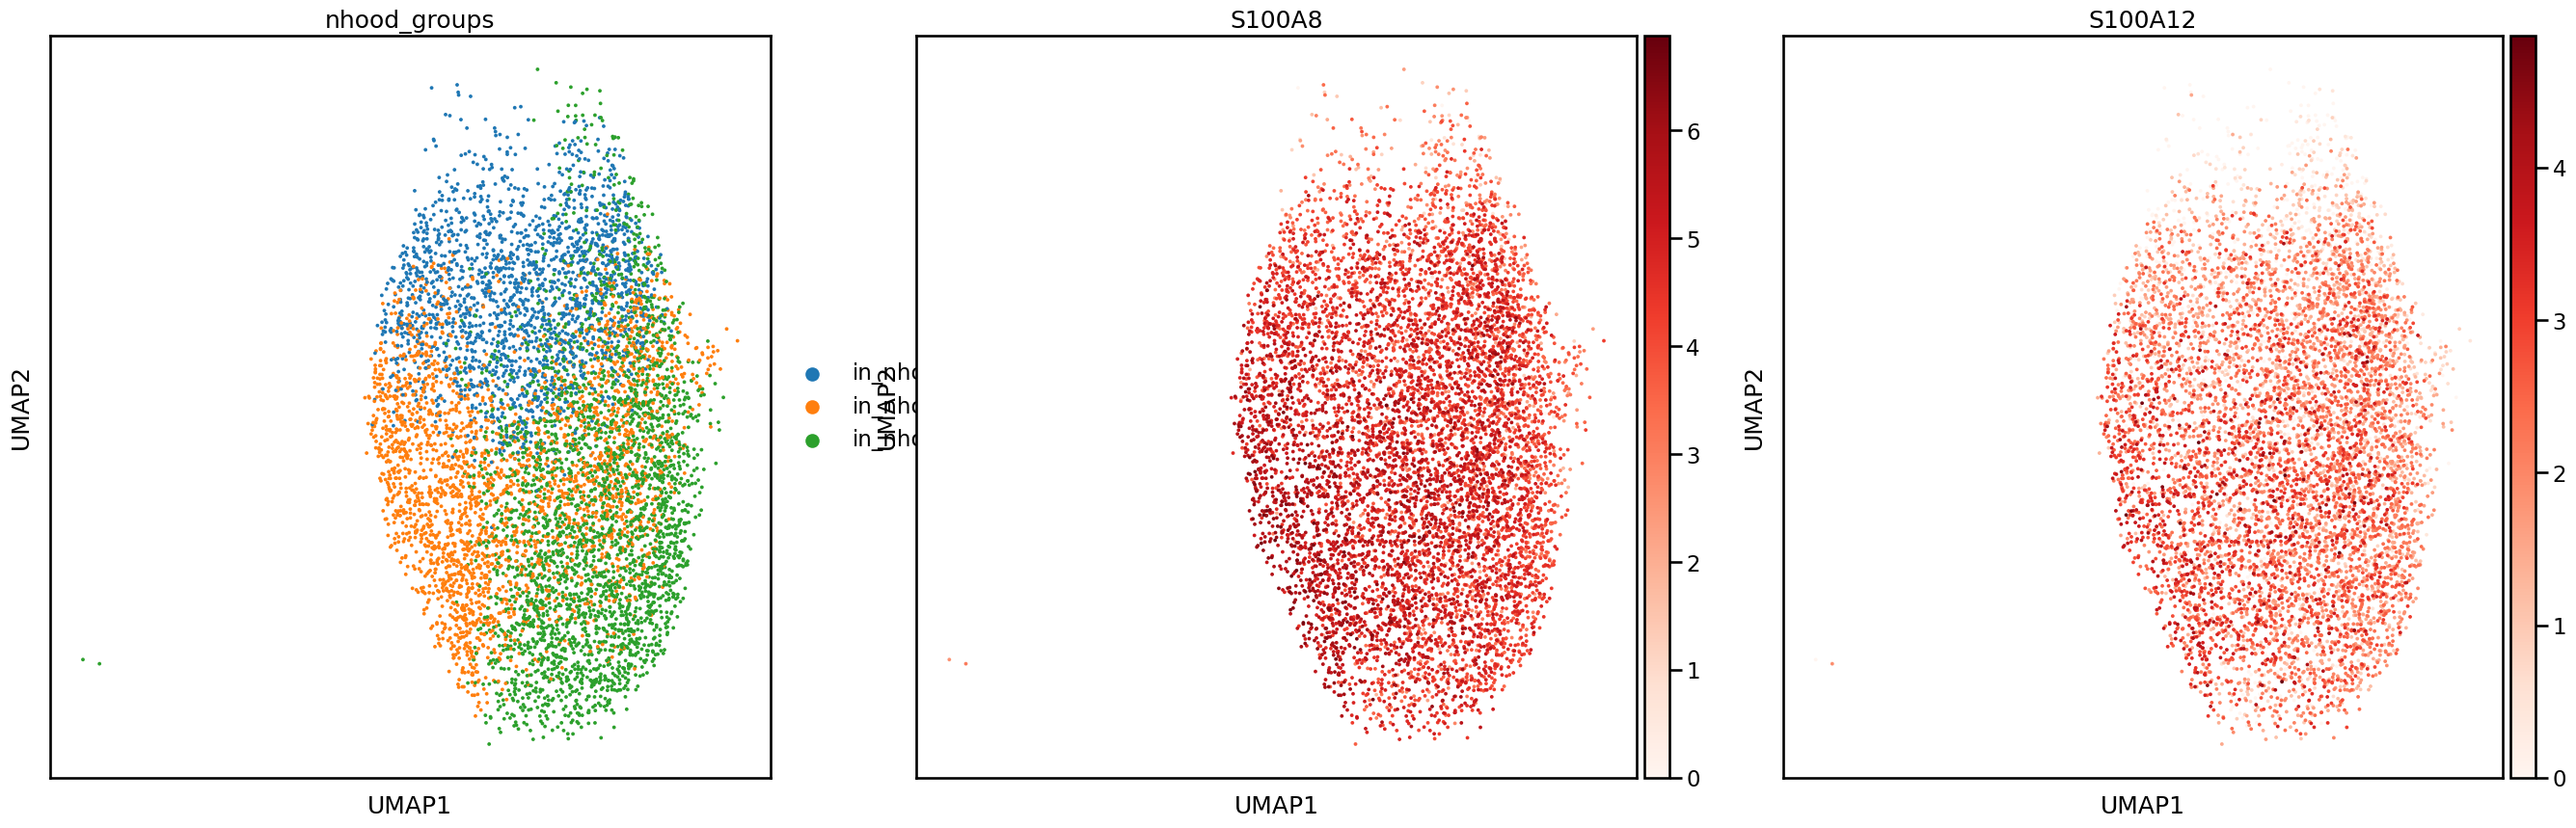

In [82]:
DE_markers = {'IFN-high markers':['IFI30', 'HLA-DPA1', 'HLA-DRA', 'HLA-DRB1', 'HLA-DPB1'], 
              'IFN-low markers':['S100A8', 'S100A12']}
sc.pl.umap(adata[(adata.obs['author_cell_type_broad'] == 'CD14_mono') & (~adata.obs['nhood_groups'].isna())], color=['nhood_groups'] + DE_markers['IFN-high markers'], 
           cmap="Reds", size=30)

sc.pl.umap(adata[(adata.obs['author_cell_type_broad'] == 'CD14_mono') & (~adata.obs['nhood_groups'].isna())], color=['nhood_groups'] + DE_markers['IFN-low markers'], 
           cmap="Reds", size=30)

In [75]:
cors = []
for gene in DE_markers['IFN-high markers']:
    x = adata[(adata.obs['author_cell_type_broad'] == 'CD14_mono') & (adata.obs['nhood_groups'].isin(['in_nhoods_high_ifn_enr', 'in_nhoods_low_ifn_enr']))].obs['IFN_signature']
    y = adata[(adata.obs['author_cell_type_broad'] == 'CD14_mono') & (adata.obs['nhood_groups'].isin(['in_nhoods_high_ifn_enr', 'in_nhoods_low_ifn_enr']))][:,gene].X.toarray()

    cors.append([gene, scipy.stats.pearsonr(x,y)])

In [76]:
cors

[['IFI30',
  PearsonRResult(statistic=array([0.07640471367818479], dtype=object), pvalue=1.7386967570664652e-07)],
 ['HLA-DPA1',
  PearsonRResult(statistic=array([0.1105425022722988], dtype=object), pvalue=3.671152464593141e-14)],
 ['HLA-DRA',
  PearsonRResult(statistic=array([0.0650185510554266], dtype=object), pvalue=8.797007226254785e-06)],
 ['HLA-DRB1',
  PearsonRResult(statistic=array([0.07005071717052108], dtype=object), pvalue=1.6708456225953967e-06)],
 ['HLA-DPB1',
  PearsonRResult(statistic=array([0.05293354890796578], dtype=object), pvalue=0.00029762463399906274)]]

In [79]:
cors = []
for gene in DE_markers['IFN-low markers']:
    x = adata[(adata.obs['author_cell_type_broad'] == 'CD14_mono') & (adata.obs['nhood_groups'].isin(['in_nhoods_high_ifn_enr', 'in_nhoods_low_ifn_enr']))].obs['IFN_signature']
    y = adata[(adata.obs['author_cell_type_broad'] == 'CD14_mono') & (adata.obs['nhood_groups'].isin(['in_nhoods_high_ifn_enr', 'in_nhoods_low_ifn_enr']))][:,gene].X.toarray()

    cors.append([gene, scipy.stats.pearsonr(x,y)])

In [80]:
cors

[['S100A8',
  PearsonRResult(statistic=array([-0.05525955269269143], dtype=object), pvalue=0.00015901515640178435)],
 ['S100A12',
  PearsonRResult(statistic=array([-0.14308432452719275], dtype=object), pvalue=9.072866720485139e-23)]]

Read data from Shulte-Shrepping et al.

In [317]:
adata_validate = sc.read_h5ad('/nfs/team205/ed6/data/PBMC_CZI_integration_filtered/10_1016_j_cell_2020_08_001.h5ad', backed=True)

In [318]:
mono_clusters = ['HLA-DR+ CD83+ Monocytes', 'HLA-DR- S100A+ Monocytes', 'Classical Monocytes']

In [319]:
adata_validate = adata_validate[adata_validate.obs['cluster_labels_res.0.4'].isin(mono_clusters)].to_memory()
adata_validate

AnnData object with n_obs × n_vars = 25390 × 33228
    obs: 'COVID.19.related_medication_and_anti.microbials', 'age', 'cluster_labels_res.0.4', 'Dataset', 'sample', 'disease_original', 'disease_general', 'COVID-19 Condition', 'Lineage', 'Cell.group', 'Cell.class_reannotated', 'n_genes', 'n_counts', 'percent_mito', 'tissue_original', 'tissue_ontology_term_id', 'disease_ontology_term_id', 'patient', 'cell_type_ontology_term_id', 'assay_ontology_term_id', 'development_stage_ontology_term_id', 'ethnicity_ontology_term_id', 'sex_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'ethnicity', 'development_stage'
    var: 'feature_biotype', 'feature_is_filtered', 'feature_name', 'feature_reference'
    uns: 'X_normalization', 'doi', 'layer_descriptions', 'schema_version', 'title'
    obsm: 'X_umap'

In [106]:
import celltypist

In [386]:
adata_monos = adata[(adata.obs['author_cell_type_broad'].isin(['CD14_mono']))].copy()

DE_genes = DE_monos_ifn['gene_name'].to_list()
adata_monos = adata_monos[:,DE_genes].copy()

adata_monos.var_names = adata_monos.var['gene_id'].values

# adata_monos.obs['labels'] = 
adata_monos.obs['nhood_groups'] = np.where((adata_monos.obs['nhood_groups'].isna()) & (adata_monos.obs['author_cell_type_broad'] == 'CD14_mono'), 
                                           'in_nhoods_other_CD14_monos', adata_monos.obs['nhood_groups'])


adata_monos.X = adata_monos.layers['counts'].copy()
sc.pp.normalize_total(adata_monos, target_sum=10000)
sc.pp.log1p(adata_monos)

In [334]:
## Downsample to equal sizes per cell type
sample_obs = []
for g in adata_monos.obs['nhood_groups'].unique():
    sample_obs.extend(np.random.choice(adata_monos[adata_monos.obs['nhood_groups'] == g].obs_names, replace=False, size=1900).tolist())

adata_monos = adata_monos[sample_obs].copy()

In [335]:
adata_monos.obs[['nhood_groups']].value_counts()

nhood_groups              
in_nhoods_high_ifn_enr        1900
in_nhoods_low_ifn_enr         1900
in_nhoods_other_CD14_monos    1900
dtype: int64

In [336]:
mono_model = celltypist.train(adata_monos, labels = 'nhood_groups', n_jobs = 10, feature_selection = False)

In [337]:
mono_model

CellTypist model with 3 cell types and 6226 features
    date: 2023-04-12 10:49:12.330367
    cell types: in_nhoods_high_ifn_enr, in_nhoods_low_ifn_enr, in_nhoods_other_CD14_monos
    features: ENSG00000165949, ENSG00000185885, ..., ENSG00000141543

In [326]:
adata_validate.X = adata_validate.raw.X.copy()
sc.pp.normalize_total(adata_validate, target_sum=10000)
sc.pp.log1p(adata_validate)

In [327]:
# adata_validate.var['feature_name'] = adata_validate.var_names.values
# adata_validate.var_names = adata_validate.var['feature_id'].values

In [338]:
predictions = celltypist.annotate(adata_validate, model = mono_model, majority_voting = False)

In [339]:
adata_validate = predictions.to_adata()

<AxesSubplot: xlabel='predicted_labels', ylabel='disease_original'>

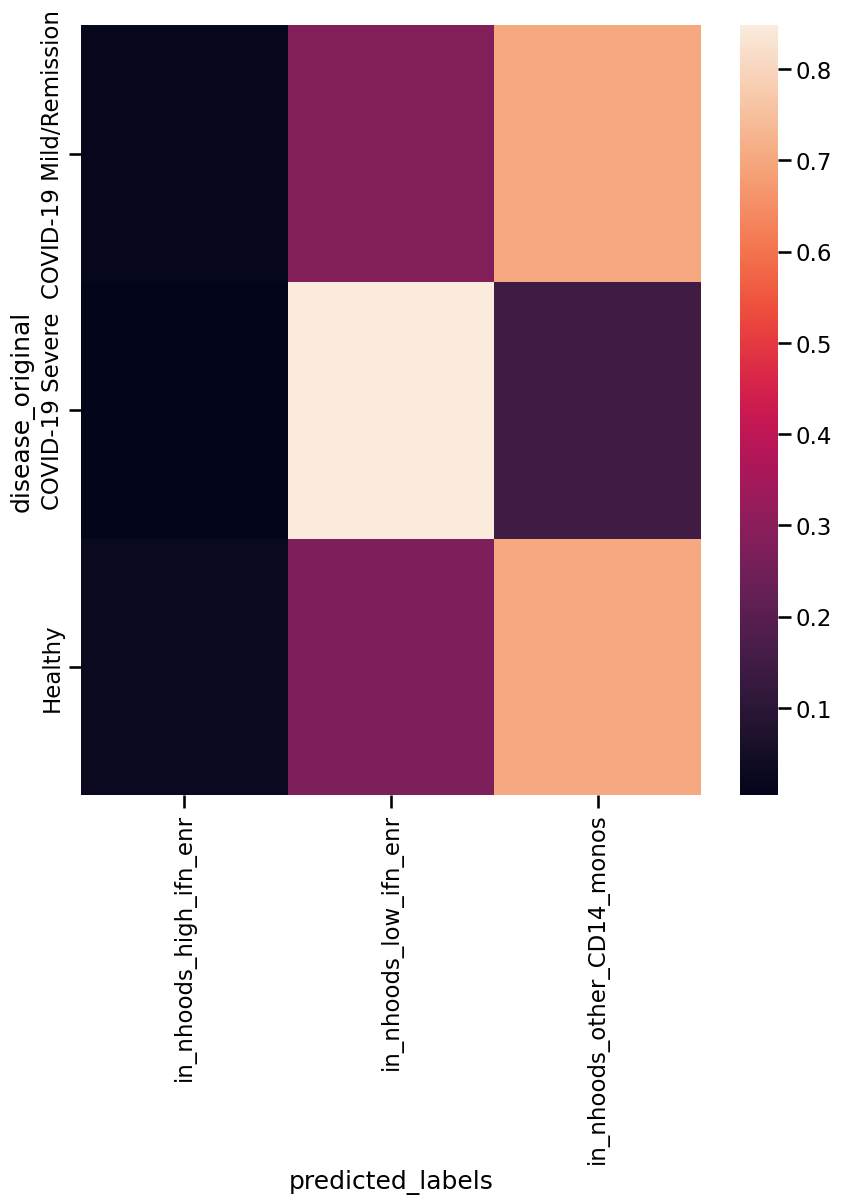

In [340]:
sns.heatmap(sc.metrics.confusion_matrix('disease_original', 'predicted_labels',data=adata_validate.obs))

In [341]:
predictions.adata.obs['ct_severity'] = predictions.adata.obs['cluster_labels_res.0.4'].astype("str") + " - " +  predictions.adata.obs['disease_original'].astype("str")

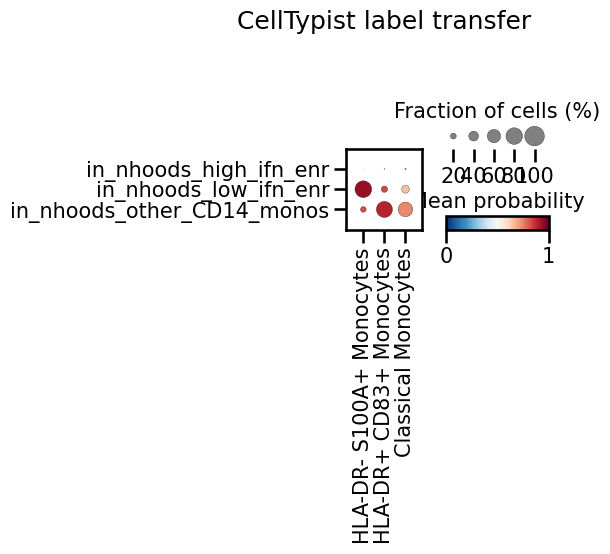

In [342]:
celltypist.dotplot(predictions, use_as_reference = 'cluster_labels_res.0.4', 
                   use_as_prediction = 'predicted_labels')

In [356]:
pl_df = adata_validate.obs[['predicted_labels', 'cluster_labels_res.0.4']]
pl_df['Shulte_labels'] = np.where(pl_df['cluster_labels_res.0.4'] != 'HLA-DR- S100A+ Monocytes', 'other CD14+ Monocytes', pl_df['cluster_labels_res.0.4'])

/tmp/ipykernel_14100/1146960935.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pl_df['Shulte_labels'] = np.where(pl_df['cluster_labels_res.0.4'] != 'HLA-DR- S100A+ Monocytes', 'other CD14+ Monocytes', pl_df['cluster_labels_res.0.4'])


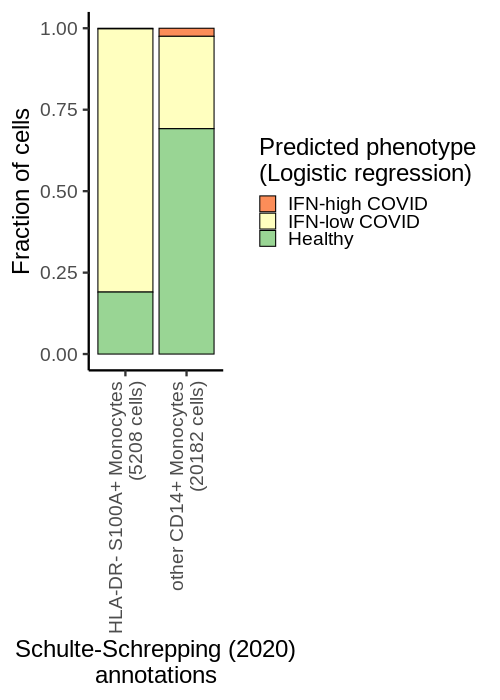

In [441]:
%%R -i pl_df -h 700 -w 500
pl_df %>%
group_by(Shulte_labels) %>%
mutate(n_cells=n()) %>%
ungroup() %>%
mutate(Shulte_labels = paste0(Shulte_labels, '\n(', n_cells, ' cells)')) %>%
ggplot(aes(Shulte_labels, fill=predicted_labels)) +
geom_bar(position='fill', color='black') +
scale_fill_brewer(palette='Spectral', 
                      labels=c('in_nhoods_high_ifn_enr' = 'IFN-high COVID', 'in_nhoods_low_ifn_enr' = 'IFN-low COVID', 'in_nhoods_other_CD14_monos' = 'Healthy'),
                      name='Predicted phenotype\n(Logistic regression)'
                     )+
ylab('Fraction of cells') +
xlab('Schulte-Schrepping (2020)\nannotations') +
theme_classic(base_size=24) +
theme(axis.text.x=element_text(angle=90, hjust=1, vjust=0.5)) +
ggsave(paste0(figdir, 'logistic_regression_monos_shulte.pdf'), height=9, width=7) +
ggsave(paste0(figdir, 'logistic_regression_monos_shulte.png'), height=9, width=7)

In [383]:
counts_df = pl_df[['Shulte_labels', 'predicted_labels']].value_counts()
counts_df.reset_index().groupby('Shulte_labels').sum()

0
Shulte_labels                  
HLA-DR- S100A+ Monocytes   5208
other CD14+ Monocytes     20182

In [389]:
5722/20182

0.28351996828857395

In [209]:
# adata_validate.var = adata_validate.var.reset_index().set_index('feature_name')

# adata_validate.var_names = adata_validate.var_names.astype(str)

# adata_monos.var_names = adata_monos.var['gene_name'].values

# sc.pl.dotplot(adata_monos, ['IFI30', 'HLA-DRA'], groupby='nhood_groups', use_raw=False, figsize=(10,3))

### Compare to CR design

In [4]:
data_dir = '/lustre/scratch117/cellgen/team205/ed6/PBMC_COVID/'
adata_c = milopy.utils.read_milo_adata(data_dir + 'PBMC_COVID.subsample500cells.design._PC.post_milo.h5ad')

In [403]:
milo_res_c = adata_c.uns['nhood_adata'].obs.copy()

In [404]:
mono_res_c = milo_res_c[milo_res_c.nhood_annotation.isin(['CD14_mono', 'CD16_mono'])]

In [405]:
%%R -i mono_res_c
head(mono_res_c)

                                          index_cell kth_distance
9  10_1038_s41591_021_01329_2-S12_CCTTCGAGTTTAGGAA-1    0.8902713
12 10_1038_s41591_021_01329_2-S12_GAACATCGTCGAGTTT-1    1.1324588
17 10_1038_s41591_021_01329_2-S11_AATCGGTCAGGATCGA-1    2.0115697
18 10_1038_s41591_021_01329_2-S11_ACTTGTTTCTTTACGT-1    1.0588832
24 10_1038_s41591_021_01329_2-S11_ACGATACAGATGGGTC-1    1.0591626
25 10_1038_s41591_021_01329_2-S11_GTCTCGTAGTTTCCTT-1    0.8993581
   nhood_annotation nhood_annotation_frac      logFC   logCPM           F
9         CD14_mono             0.9411765 0.92466581 9.069653  4.46760623
12        CD14_mono             0.5421687 0.42374733 8.849825  0.84082931
17        CD14_mono             0.5217391 0.08132151 8.658427  0.04571149
18        CD14_mono             0.7087912 1.23369293 8.904684  7.68013339
24        CD14_mono             0.6694215 1.40790100 8.684696 10.19286772
25        CD14_mono             0.6963563 2.05895088 9.102759 18.62473667
        PValue      

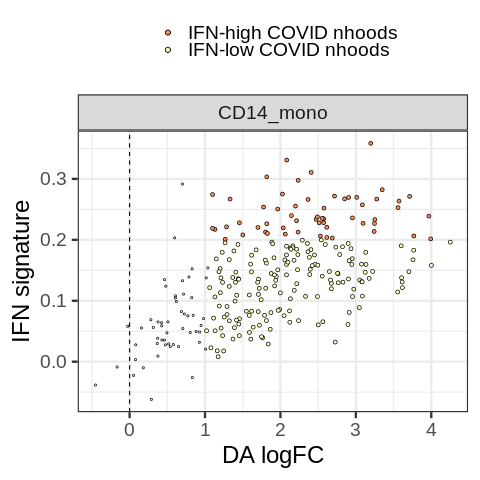

In [406]:
%%R
mono_res_c %>%
    filter(nhood_annotation == 'CD14_mono') %>%
    ggplot(aes(logFC, nhood_IFN_signature)) +
    geom_point(size=0.7, shape=21) +
    geom_point(data=. %>% filter(SpatialFDR < 0.1 & logFC > 1 & nhood_IFN_signature > 0.2), 
               shape=21,
               aes(fill='IFN-high COVID nhoods')) +
    geom_point(data=. %>% filter(SpatialFDR < 0.1 & logFC > 1 & nhood_IFN_signature < 0.2), 
               shape=21,
               aes(fill='IFN-low COVID nhoods')) +
    facet_wrap(nhood_annotation~.) +
    guides(fill=guide_legend(title='', override.aes = list(size=2), ncol=1)) +
    theme_bw(base_size=24) +
    scale_fill_brewer(palette='Spectral', name='') +
    geom_vline(xintercept=0, linetype=2) +
#     geom_hline(yintercept=0, linetype='dashed', color='red') +
    xlab("DA logFC") + ylab("IFN signature") +
    theme(legend.position='top') +
    ggsave(paste0(figdir, 'groups_CD14_monos_CR.png'), height=7, width=7) +
    ggsave(paste0(figdir, 'groups_CD14_monos_CR.pdf'), height=7, width=7)
    

In [407]:
## Select nhoods of interest
cd14_mono_res = mono_res_c[mono_res_c.nhood_annotation == 'CD14_mono']
low_ifn_monos_nhoods = cd14_mono_res.index[(cd14_mono_res.SpatialFDR < 0.1) & (cd14_mono_res.logFC > 0) & (cd14_mono_res.nhood_IFN_signature < 0.2)]
high_ifn_monos_nhoods = cd14_mono_res.index[(cd14_mono_res.SpatialFDR < 0.1) & (cd14_mono_res.logFC > 0) & (cd14_mono_res.nhood_IFN_signature > 0.2)]

In [408]:
other_monos_nhoods = cd14_mono_res.index[~((cd14_mono_res.SpatialFDR < 0.1) & (cd14_mono_res.logFC > 0))]

In [409]:
## Mark nhood groups
nhood_adata = adata_c.uns['nhood_adata'].copy()
nhood_adata.obs['nhood_groups'] = np.nan
nhood_adata.obs.loc[low_ifn_monos_nhoods, 'nhood_groups'] = 'low_ifn_enr'
nhood_adata.obs.loc[high_ifn_monos_nhoods, 'nhood_groups'] = 'high_ifn_enr'
nhood_adata.obs.loc[other_monos_nhoods, 'nhood_groups'] = 'other_CD14_monos'
adata_c.uns['nhood_adata'] = nhood_adata.copy()

In [416]:
# adata_c.layers['counts'] = adata_c.X.copy()

# sc.pp.normalize_per_cell(adata_c)
# sc.pp.log1p(adata_c)

In [129]:
# ## Run DE testing
# DE_monos_ifn = find_nhood_group_markers(
#     adata_c[adata_c.obs['author_cell_type'] == 'CD14_mono' ], 
#     test_group='low_ifn_enr', 
#     ctrl_group='high_ifn_enr', 
#     confounders_obs=['Site'],
#     n_hvgs = 7500
#     )


# %%R -i DE_monos_ifn -w 800 -h 600 -i figdir
# max_lfc = 15
# DE_monos_ifn$lfc <- ifelse(abs(DE_monos_ifn$lfc) > max_lfc, sign(DE_monos_ifn$lfc) * Inf, DE_monos_ifn$lfc)
# DE_monos_ifn %>%
# #     filter(contrast == 'mild_enr-other') %>%
#     mutate(signif = adj_pval < 0.01) %>%
#     mutate(label = ifelse(signif & (abs(lfc) > 0.75), as.character(gene_name), NA)) %>%
#     ggplot(aes(lfc, -log10(adj_pval))) + 
#     geom_point(size=0.5) +
#     geom_point(data=. %>% filter(signif), color='red') +
#     ggrepel::geom_text_repel(aes(label=label), color='red') +
#     theme_bw(base_size=18) +
#     xlab("DE log-Fold Change") +
#     ylab('-log10(Adj. P-value)') +
#     ggsave(paste0(figdir, 'volcano_CD14_monos_CR.png'), height=7, width=7) +
#     ggsave(paste0(figdir, 'volcano_CD14_monos_CR.pdf'), height=7, width=7) 

In [417]:
import diff2atlas

In [418]:
assign_cells_2_nhood_group(adata_c)

In [419]:
groups = adata_c.uns['nhood_adata'].obs['nhood_groups'].dropna().unique()
min_n_nhoods = 3
adata_c.obs['nhood_groups'] = np.nan
adata_c.obs['nhood_groups'] = adata_c.obs[[f'in_nhoods_{g}' for g in groups]].idxmax(1)
## Keep only if cell is in at least min_n_nhoods nhoods of the same group
adata_c.obs.loc[~(adata_c.obs[[f'in_nhoods_{g}' for g in groups]] > min_n_nhoods).any(1), 'nhood_groups'] = np.nan 


In [420]:
adata_c.obs['nhood_groups']

10_1038_s41591_021_01329_2-S11_GAGTCCGGTTCAGGCC-1          NaN
10_1038_s41591_021_01329_2-S12_ACTGTCCTCTCGTATT-1          NaN
10_1038_s41591_021_01329_2-S12_CTCTAATAGTTTCCTT-1          NaN
10_1038_s41591_021_01329_2-S12_GCATACAGTAATCGTC-1          NaN
10_1038_s41591_021_01329_2-S12_GACTGCGTCCTTTCGG-1          NaN
                                                          ... 
10_1038_s41591_021_01329_2-AGCAGCCGTCACTTCC-newcastle74    NaN
10_1038_s41591_021_01329_2-TACTTACTCAAGGCTT-newcastle74    NaN
10_1038_s41591_021_01329_2-CATCAAGGTAACGACG-newcastle74    NaN
10_1038_s41591_021_01329_2-CACAGGCCAAGCCATT-newcastle74    NaN
10_1038_s41591_021_01329_2-CATCCACGTTCGTGAT-newcastle74    NaN
Name: nhood_groups, Length: 62509, dtype: object

In [421]:
n_cells_sev = adata_c.obs[['nhood_groups', 'Status_on_day_collection_summary', 'donor_id']].dropna()
n_cells_sev['n_cells'] = 1
n_cells_sev = n_cells_sev.groupby(['nhood_groups', 'Status_on_day_collection_summary', 'donor_id']).sum().reset_index()

In [422]:
plt.rcParams['figure.figsize'] = [10, 10]
# n_cells_sev = adata_c.obs[['nhood_groups', 'Status_on_day_collection_summary', 'Days_from_onset', 'donor_id']].dropna().value_counts().reset_index()
# n_cells_sev['n_cells'] = n_cells_sev[0]

# n_cells_sev
n_cells_sev = adata_c.obs[['nhood_groups', 'Status_on_day_collection_summary', 'donor_id']].dropna()
n_cells_sev['n_cells'] = 1
n_cells_sev = n_cells_sev.groupby(['nhood_groups', 'Status_on_day_collection_summary', 'donor_id']).sum().reset_index()
order_severity = ['Healthy', 'Asymptomatic', 'Mild', "Moderate", "Severe", "Critical"]
# sns.boxplot(data=n_cells_sev, x='Status_on_day_collection_summary', y='n_cells', hue='nhood_groups', order=order_severity)
# sns.stripplot(data=n_cells_sev, x='Status_on_day_collection_summary', y='n_cells', hue='nhood_groups', 
#               color='black', position='dodge',
#               order=order_severity)
# n_cells_sev = n_cells_sev[~n_cells_sev.Days_from_onset.isin(['Healthy', 'LPS', 'Not_known', 'nan'])]


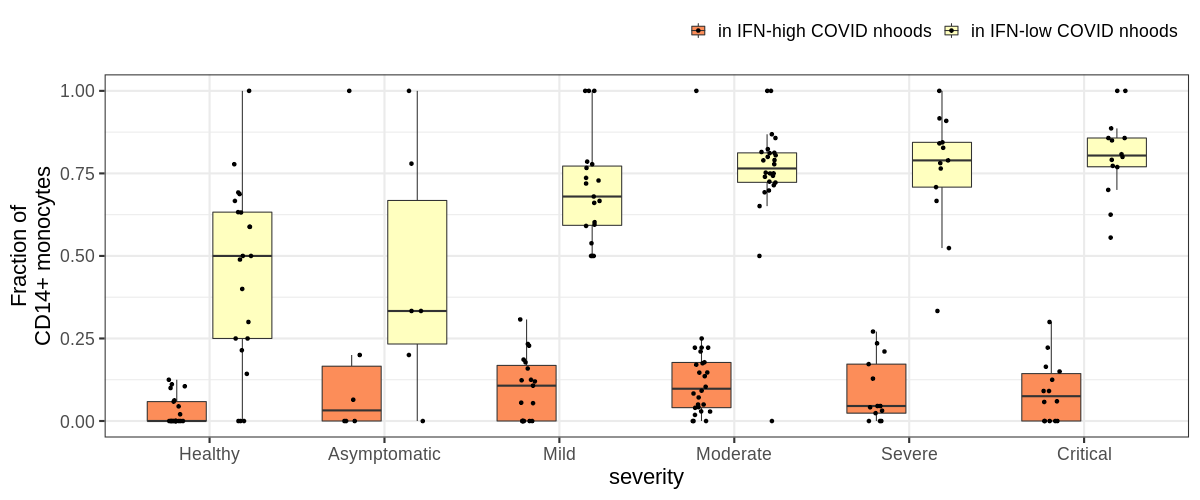

In [423]:
%%R -i order_severity -i n_cells_sev -w 1200 -h 500 -i figdir
n_cells_sev %>%
    filter(Status_on_day_collection_summary %in% order_severity) %>%
    mutate(severity = factor(Status_on_day_collection_summary, levels=order_severity)) %>%
    group_by(donor_id, severity) %>%
    mutate(frac_cells = n_cells/sum(n_cells)) %>%
    ungroup() %>%
#     filter(severity == 'Asymptomatic') %>%
#     select(nhood_groups, frac_cells, donor_id)
    filter(nhood_groups != 'in_nhoods_other_CD14_monos') %>%
    ggplot(aes(severity, frac_cells, fill = nhood_groups)) +
    geom_boxplot(outlier.alpha=0) +
    geom_point(position=position_jitterdodge(jitter.width=0.1)) +
#     facet_wrap(nhood_groups~.) +
#     scale_y_log10() +
    scale_fill_brewer(palette='Spectral', 
                      labels=c('in_nhoods_high_ifn_enr' = 'in IFN-high COVID nhoods', 'in_nhoods_low_ifn_enr' = 'in IFN-low COVID nhoods'),
                      name=''
                     ) +
    ylab('Fraction of\nCD14+ monocytes') +
    theme_bw(base_size=22) +
    theme(legend.position='top', legend.justification=c(1,1)) +
    ggsave(paste0(figdir, 'CD14_monos_severity_CR.png'), height=7, width=10) +
    ggsave(paste0(figdir, 'CD14_monos_severity_CR.pdf'), height=7, width=10) 

In [424]:
%%R -i order_severity -i n_cells_sev -w 1200 -h 500 -o ttest_res 
ttest_res <- n_cells_sev %>%
    filter(Status_on_day_collection_summary %in% order_severity) %>%
    mutate(severity = factor(Status_on_day_collection_summary, levels=order_severity)) %>%
    group_by(donor_id, severity) %>%
    mutate(frac_cells = n_cells/sum(n_cells)) %>%
    ungroup() %>%
    filter(nhood_groups != 'in_nhoods_other_CD14_monos') %>%
    group_by(nhood_groups, Status_on_day_collection_summary) %>%
    summarise(fracs = list(frac_cells))  %>%
    ungroup() %>%
    pivot_wider(id_cols=nhood_groups, names_from=Status_on_day_collection_summary, values_from=fracs) %>%
        group_by(nhood_groups) %>%
    mutate(pval_vsAsymp = wilcox.test(unlist(Healthy), unlist(Asymptomatic))$p.value, stat_vsAsymp = wilcox.test(unlist(Healthy), unlist(Asymptomatic))$statistic,
          pval_vsMild = wilcox.test(unlist(Healthy), unlist(Mild))$p.value, stat_vsMild = wilcox.test(unlist(Healthy), unlist(Mild))$statistic,
          pval_vsModerate = wilcox.test(unlist(Healthy), unlist(Moderate))$p.value, stat_vsModerate = wilcox.test(unlist(Healthy), unlist(Moderate))$statistic,
          pval_vsCrit = wilcox.test(unlist(Healthy), unlist(Critical))$p.value, stat_vsCrit = wilcox.test(unlist(Healthy), unlist(Critical))$statistic,
          pval_MildvsCrit = wilcox.test(unlist(Moderate), unlist(Critical))$p.value, stat_MildvsCrit = wilcox.test(unlist(Moderate), unlist(Critical))$statistic) %>%
    select( - c(order_severity))

`summarise()` has grouped output by 'nhood_groups'. You can override using the
`.groups` argument.


In [425]:
ttest_res

nhood_groups  pval_vsAsymp  stat_vsAsymp  pval_vsMild  \
1  in_nhoods_high_ifn_enr      0.325737          47.5     0.019023   
2   in_nhoods_low_ifn_enr      0.976683          64.0     0.002073   

   stat_vsMild  pval_vsModerate  stat_vsModerate  pval_vsCrit  stat_vsCrit  \
1        118.0         0.000289            106.5     0.048352         92.0   
2         85.5         0.000011             67.0     0.000086         30.0   

   pval_MildvsCrit  stat_MildvsCrit  
1         0.325743            217.0  
2         0.211808            137.5

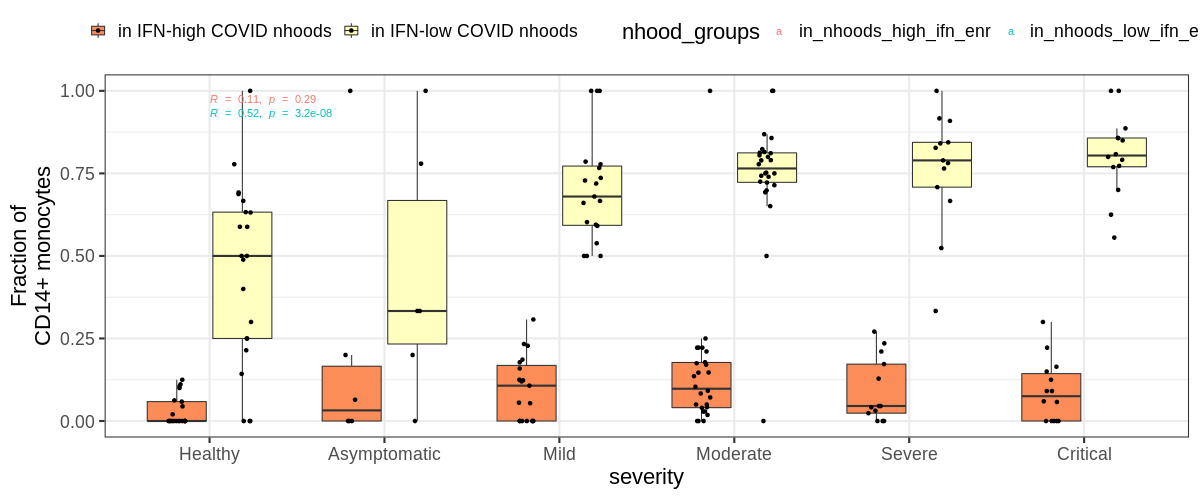

In [426]:
%%R -i order_severity -i n_cells_sev -w 1200 -h 500 -i figdir
n_cells_sev %>%
    filter(Status_on_day_collection_summary %in% order_severity) %>%
    mutate(severity = factor(Status_on_day_collection_summary, levels=order_severity)) %>%
    group_by(donor_id, severity) %>%
    mutate(frac_cells = n_cells/sum(n_cells)) %>%
    ungroup() %>%
#     filter(severity == 'Asymptomatic') %>%
#     select(nhood_groups, frac_cells, donor_id)
    filter(nhood_groups != 'in_nhoods_other_CD14_monos') %>%
    ggplot(aes(severity, frac_cells, fill = nhood_groups)) +
    geom_boxplot(outlier.alpha=0) +
    geom_point(position=position_jitterdodge(jitter.width=0.1)) +
#     facet_wrap(nhood_groups~.) +
#     scale_y_log10() +
    scale_fill_brewer(palette='Spectral', 
                      labels=c('in_nhoods_high_ifn_enr' = 'in IFN-high COVID nhoods', 'in_nhoods_low_ifn_enr' = 'in IFN-low COVID nhoods'),
                      name=''
                     ) +
    ylab('Fraction of\nCD14+ monocytes') +
    theme_bw(base_size=22) +
    theme(legend.position='top', legend.justification=c(1,1)) +
ggpubr::stat_cor(aes(x=as.numeric(severity), color=nhood_groups))

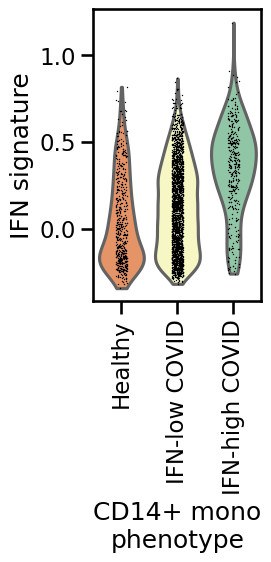

In [427]:
mono_phenotype = {
    'in_nhoods_low_ifn_enr':'IFN-low COVID',
    'in_nhoods_high_ifn_enr':'IFN-high COVID',
    'in_nhoods_other_CD14_monos':'Healthy',
    }

# with rc_context({'figure.figsize':[3,4]}):
#     adata.obs['mono_phenotype'] = [mono_phenotype[x] if x in mono_phenotype.keys() else np.nan for x in adata.obs['nhood_groups']]
#     adata.obs['mono_phenotype'] = adata.obs['mono_phenotype'].astype('category').cat.reorder_categories(['Healthy','IFN-low COVID', 'IFN-high COVID'])
#     sc.pl.violin(adata, 'IFN_signature', groupby='mono_phenotype', palette='Spectral', rotation=90, 
#                  xlabel='CD14+ mono\nphenotype', ylabel='IFN signature', save='mono_phenotypes_ACR.png');
    
with rc_context({'figure.figsize':[3,4]}):
    adata_c.obs['mono_phenotype'] = [mono_phenotype[x] if x in mono_phenotype.keys() else np.nan for x in adata_c.obs['nhood_groups']]
    adata_c.obs['mono_phenotype'] = adata_c.obs['mono_phenotype'].astype('category').cat.reorder_categories(['Healthy','IFN-low COVID', 'IFN-high COVID'])
    sc.pl.violin(adata_c, 'IFN_signature', groupby='mono_phenotype', palette='Spectral', rotation=90, 
                 xlabel='CD14+ mono\nphenotype', ylabel='IFN signature', save='mono_phenotypes_CR.pdf');
# sc.pl.violin(adata, 'IFN_signature',groupby='nhood_groups')
# sc.pl.violin(adata_c, 'IFN_signature',groupby='nhood_groups')

In [428]:
adata_c.var = adata_c.var.drop('gene_name', 1).copy()

/tmp/ipykernel_346/3198556710.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  adata_c.var = adata_c.var.drop('gene_name', 1).copy()


KeyError: "['gene_name'] not found in axis"

In [429]:
adata.var_names = adata.var['gene_id'].values

/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/anndata/_core/anndata.py:895: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    ['ENSG00000177757', 'ENSG00000225880', 'ENSG00000230368', 'ENSG00000187634', 'ENSG00000188976']

    Inferred to be: categorical

  names = self._prep_dim_index(names, "var")


In [430]:
adata_c.var = pd.concat([adata_c.var, adata.var], 1)
adata_c.var['gene_name'] = np.where(adata_c.var['gene_name'].isna(), adata_c.var_names, adata_c.var['gene_name'])

/tmp/ipykernel_346/2337986748.py:1: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  adata_c.var = pd.concat([adata_c.var, adata.var], 1)


In [431]:
## Run DE testing
DE_monos_ifn_CR = find_nhood_group_markers(
    adata_c[adata_c.obs['author_cell_type'] == 'CD14_mono' ], 
    test_group='low_ifn_enr', 
    ctrl_group='high_ifn_enr', 
    confounders_obs=['Site'],
    n_hvgs = 7500
    )


/nfs/team205/ed6/bin/diff2atlas/diff2atlas/utils.py:19: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['in_nhoods'] = in_nhoods
/tmp/ipykernel_346/3734755657.py:67: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  de_res_df.drop('name', 1, inplace=True)


In [432]:
DE_monos_ifn_CR

pval  adj_pval  f_statistic  df1         df2        lfc  \
gene_name                                                                      
ENSG00000226471  0.309246  0.823697     1.038834    1  213.487378  -0.511222   
CBX2             0.133595  0.667143     2.267455    1  213.487378  -0.600857   
GOLIM4           0.122003  0.657461     2.410526    1  213.487378  -0.420557   
ENSG00000267397  0.006654  0.216104     7.510395    1  213.487378  -0.274491   
LTBP2            0.979538  0.999965     0.000659    1  213.487378   0.018947   
...                   ...       ...          ...  ...         ...        ...   
NOP53            0.574797  0.910044     0.315692    1  213.487378  30.363791   
ENSG00000198090  0.825884  0.975689     0.048512    1  213.487378  -0.215029   
ENSG00000269901  0.516198  0.897834     0.422889    1  213.487378  -0.507728   
CD8B             0.733165  0.954783     0.116530    1  213.487378   0.504112   
MLLT3            0.336309  0.833749     0.928631    1  213.487378  -1.193407   

                       gene_name  
gene_name                         
ENSG00000226471  ENSG00000226471  
CBX2                        CBX2  
GOLIM4                    GOLIM4  
ENSG00000267397  ENSG00000267397  
LTBP2                      LTBP2  
...                          ...  
NOP53                      NOP53  
ENSG00000198090  ENSG00000198090  
ENSG00000269901  ENSG00000269901  
CD8B                        CD8B  
MLLT3                      MLLT3  

[7275 rows x 7 columns]

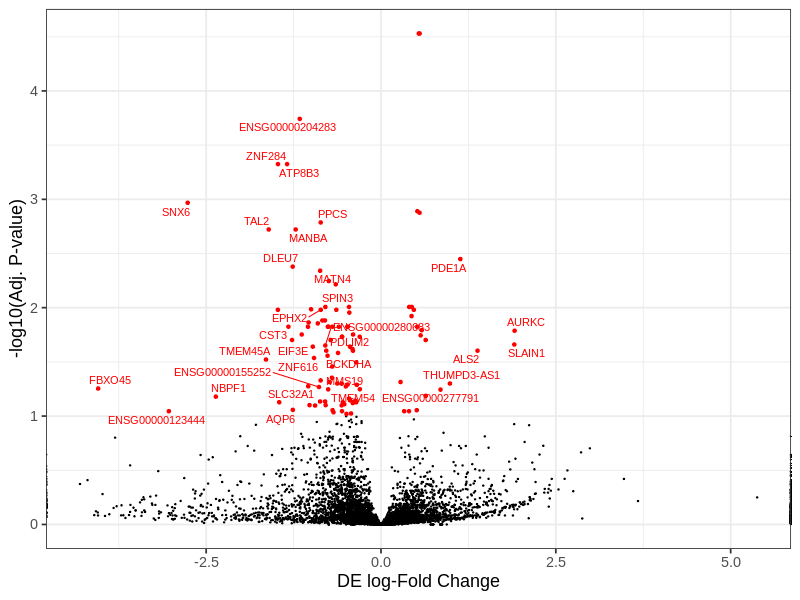

In [436]:
%%R -i DE_monos_ifn_CR -w 800 -h 600 -i figdir
max_lfc = 15
DE_monos_ifn_CR$lfc <- ifelse(abs(DE_monos_ifn_CR$lfc) > max_lfc, sign(DE_monos_ifn_CR$lfc) * Inf, DE_monos_ifn_CR$lfc)
DE_monos_ifn_CR %>%
#     filter(contrast == 'mild_enr-other') %>%
    mutate(signif = adj_pval < 0.1) %>%
    mutate(label = ifelse(signif & (abs(lfc) > 0.75), as.character(gene_name), NA)) %>%
    ggplot(aes(lfc, -log10(adj_pval))) + 
    geom_point(size=0.5) +
    geom_point(data=. %>% filter(signif), color='red') +
    ggrepel::geom_text_repel(aes(label=label), color='red') +
    theme_bw(base_size=18) +
    xlab("DE log-Fold Change") +
    ylab('-log10(Adj. P-value)') +
    ggsave(paste0(figdir, 'volcano_CD14_monos.CR.png'), height=7, width=7) +
    ggsave(paste0(figdir, 'volcano_CD14_monos.CR.pdf'), height=7, width=7) 

In [437]:
## Save for supplementary
DE_monos_ifn_CR.to_csv(data_dir + "CD14_mono.DE_results.CRdesign.csv")

## Compare designs on clustering

In [385]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

In [386]:
split_seed = 42
n_iters = 3
def label_transfer_classify(adata, n_iters = 10, split_seed=42):
    X = adata.obsm['X_scVI'].copy()
    y = adata.obs['author_cell_type'].copy()
    out_all_df = pd.DataFrame()
    for s in np.arange(split_seed, split_seed+n_iters):
        X_train, X_test, y_train, y_test = train_test_split(
                    X, y, test_size=0.2, random_state=s)

        clf = KNeighborsClassifier(
            n_neighbors=30,
            metric="euclidean"
            ).fit(X_train, y_train)
        class_out = classification_report(y_test, clf.predict(X_test), output_dict=True)
        out_df = pd.DataFrame.from_dict(class_out).T.reset_index()
        out_df['split_seed'] = s
        out_all_df = pd.concat([out_all_df, out_df])
    return(out_all_df)

In [387]:
clf_acr = label_transfer_classify(adata)

/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

In [388]:
clf_cr = label_transfer_classify(adata_c)

/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

In [389]:
clf_cr['design'] = 'CR'
clf_acr['design'] = 'ACR'
clf_results = pd.concat([clf_cr, clf_acr])

In [390]:
ct_counts = adata.obs['author_cell_type'].value_counts()
keep_cts = ct_counts[ct_counts > 100].index.astype('str')
keep_cts

Index(['NK_16hi', 'CD4.CM', 'CD4.Naive', 'B_naive', 'CD83_CD14_mono', 'CD8.TE',
       'CD8.Naive', 'CD14_mono', 'CD4.IL22', 'CD4.Tfh', 'CD8.EM', 'Platelets',
       'gdT', 'CD16_mono', 'MAIT', 'NK_56hi', 'B_switched_memory',
       'B_immature', 'RBC', 'B_malignant', 'B_non-switched_memory', 'NKT',
       'pDC', 'DC3', 'Plasma_cell_IgG', 'NK_prolif', 'B_exhausted',
       'Plasmablast', 'CD4.EM', 'Plasma_cell_IgA', 'DC2', 'C1_CD16_mono',
       'HSC_CD38pos', 'CD8.Prolif', 'Plasma_cell_IgM'],
      dtype='object')

In [391]:
mean_p_acr = clf_acr[['index','f1-score']].groupby('index').median()
mean_p_acr.columns = ['precision_ACR']
mean_p_cr = clf_cr[['index','f1-score']].groupby('index').median()
mean_p_cr.columns = ['precision_CR']
p_mean = pd.concat([mean_p_cr, mean_p_acr],1 )
p_delta = p_mean['precision_ACR'] - p_mean['precision_CR']
sorted_ixs = p_delta.sort_values().index

/tmp/ipykernel_346/1023192447.py:5: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  p_mean = pd.concat([mean_p_cr, mean_p_acr],1 )


In [392]:
clf_results['anno_group'] = [anno_labels_dict[x] if x in anno_labels_dict.keys() else np.nan for x in clf_results['index']]

In [393]:
%%R -i clf_results -i keep_cts -i sorted_ixs
head(clf_results)

                  index precision    recall  f1-score support split_seed design
1                  ASDC 0.0000000 0.0000000 0.0000000       2         42     CR
2           B_exhausted 0.7142857 0.7894737 0.7500000      76         42     CR
3            B_immature 0.7234043 0.2595420 0.3820225     131         42     CR
4           B_malignant 0.9166667 0.3586957 0.5156250      92         42     CR
5               B_naive 0.7638589 0.9515695 0.8474441    1115         42     CR
6 B_non-switched_memory 0.6296296 0.2023810 0.3063063      84         42     CR
  anno_group
1       ASDC
2     B_cell
3     B_cell
4     B_cell
5     B_cell
6     B_cell


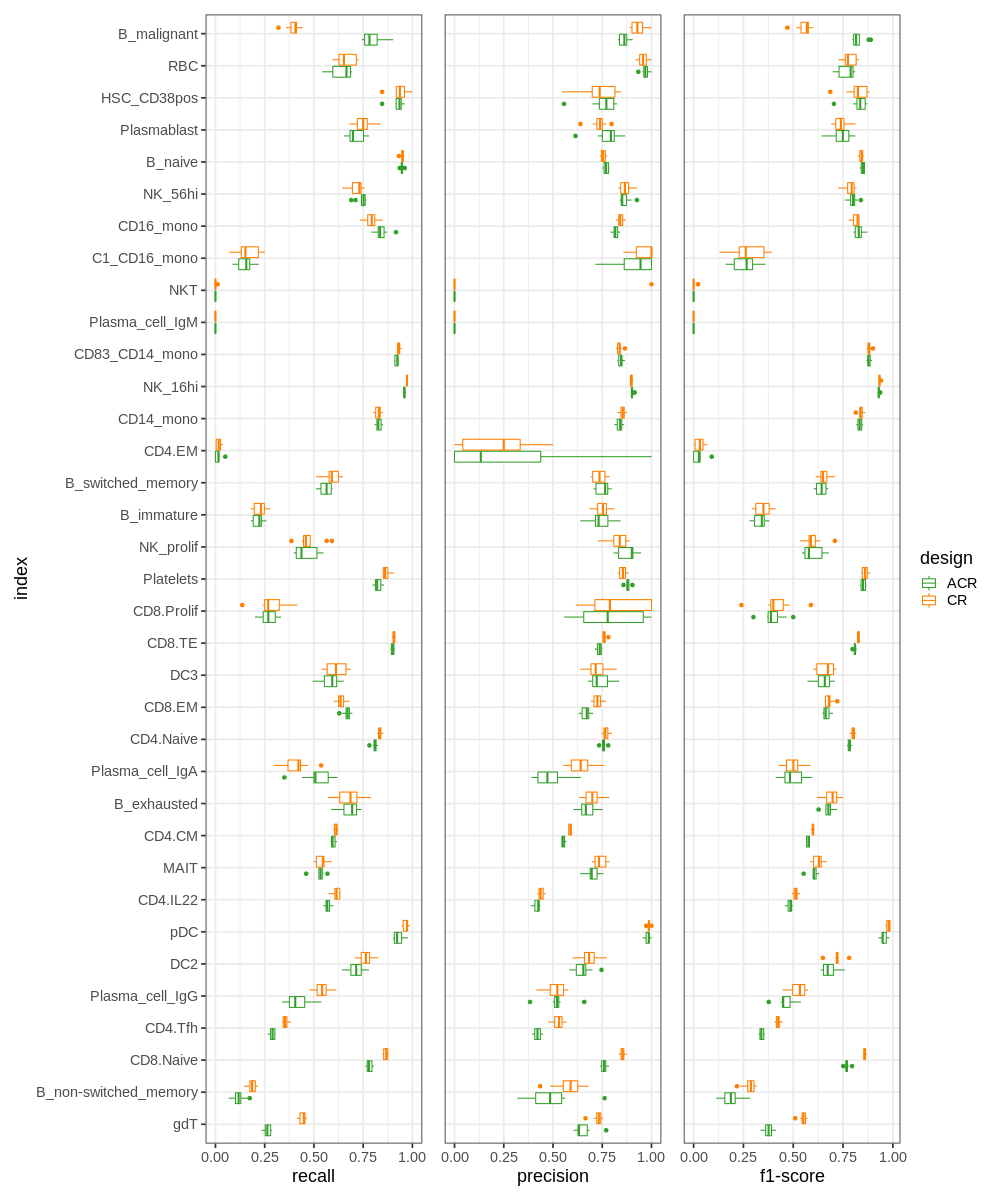

In [394]:
%%R -h 1200 -w 1000
pl_df <- clf_results %>%
    filter(index %in% unlist(keep_cts)) %>%
    group_by(index) %>%
    mutate(median_score = median(`precision`)) %>%
    ungroup() %>%
    filter(!index %in% c('accuracy', 'weighted avg', 'macro avg')) %>%
    arrange(median_score) %>%
    mutate(index = factor(index, levels=unlist(sorted_ixs))) %>%
    mutate(anno_group = ifelse(str_detect(anno_group, "NK"), "NK", anno_group)) %>%
    mutate(anno_group = ifelse( str_detect(anno_group, "ILC"), "ILC", anno_group)) %>%
    mutate(anno_group = ifelse(str_detect(anno_group, "DC"), "DC", anno_group)) %>%
    mutate(anno_group = ifelse(str_detect(anno_group, "mono"), "Monos", anno_group))
    
r_plot <- pl_df %>%
    ggplot(aes(index, `precision`, color=design)) +
    geom_boxplot() +
    coord_flip() +
    theme_bw(base_size=18) +
#     facet_grid(anno_group~., space='free', scales='free') +
    scale_color_manual(values=design_palette)
p_plot <- pl_df %>%
    ggplot(aes(index, `recall`, color=design)) +
    geom_boxplot() +
    coord_flip() +
#     facet_grid(anno_group~., space='free', scales='free') +
    theme_bw(base_size=18) +
    scale_color_manual(values=design_palette)
f_plot <- pl_df %>%
    ggplot(aes(index, `f1-score`, color=design)) +
    geom_boxplot() +
    coord_flip() +
    theme_bw(base_size=18) +
#     facet_grid(anno_group~., space='free', scales='free') +
    scale_color_manual(values=design_palette)
    
p_plot + (r_plot + remove_y_axis()) + (f_plot + remove_y_axis())+
plot_layout(guides='collect') 

In [401]:
%%R
ggsave(paste0(figdir, 'KNN_classifier_labels_F1score.png'), plot=f_plot, height=7, width=6) 
ggsave(paste0(figdir, 'KNN_classifier_labels_F1score.pdf'), plot=f_plot, height=7, width=6) 

`summarise()` has grouped output by 'design'. You can override using the
`.groups` argument.


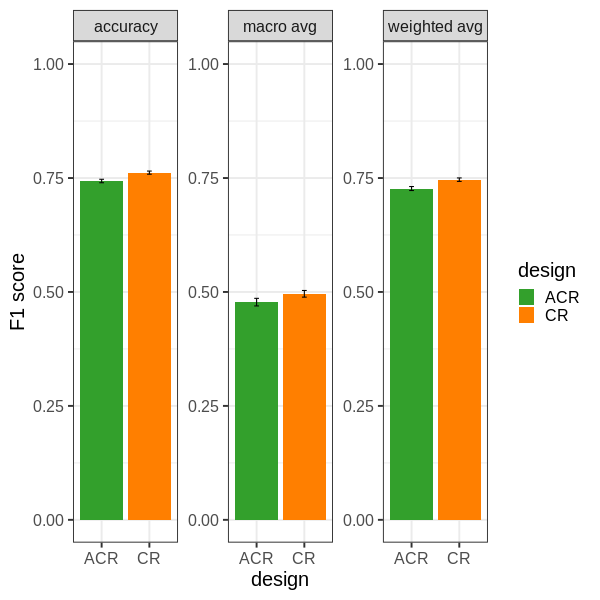

In [396]:
%%R -h 600 -w 600
clf_results %>%
    filter(index %in% c('accuracy', 'weighted avg', 'macro avg')) %>%
    group_by(design, index) %>%
    summarise(mean_score=mean(`f1-score`), sd_score=sd(`f1-score`)) %>%
    ggplot(aes(design, mean_score, fill=design)) +
    geom_col(position='dodge') +
    geom_errorbar(aes(ymin=mean_score - sd_score, ymax=mean_score + sd_score), position='dodge', width=0.1) +
    facet_wrap(index~., scales='free') +
    scale_fill_manual(values=design_palette) +
    ylim(0,1) +
    ylab("F1 score") +
    theme_bw(base_size=20) +
        ggsave(paste0(figdir, 'KNN_classifier_labels_mean.png'), height=7, width=10) +
    ggsave(paste0(figdir, 'KNN_classifier_labels_mean.pdf'), height=7, width=10) 


### Precision-recall analysis on IFN-high states stratified by cell type

In [105]:
ordered_cts = adata.obs[['IFN_signature', 'author_cell_type_broad']].groupby('author_cell_type_broad').mean().sort_values('IFN_signature').index

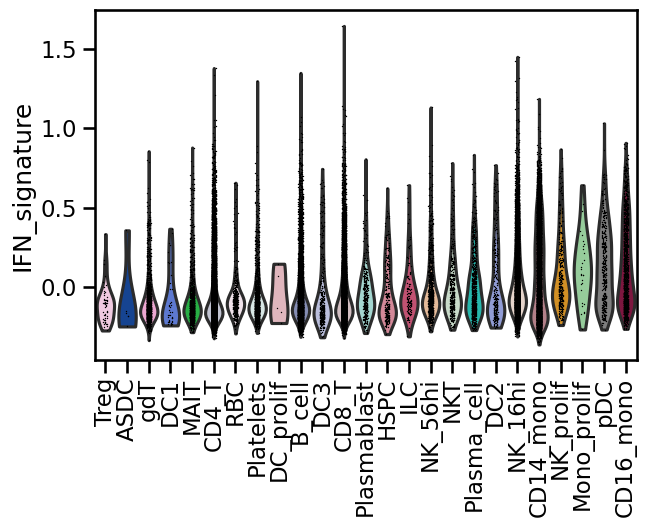

In [106]:
## Find cell types with IFN-high states
sc.pl.violin(adata,'IFN_signature', groupby='author_cell_type_broad', order=ordered_cts, rotation=90)

In [104]:
ordered_cts[::-1][0:10]

CategoricalIndex(['CD8_T', 'NK_16hi', 'CD4_T', 'B_cell', 'Platelets',
                  'CD14_mono', 'NK_56hi', 'pDC', 'CD16_mono', 'MAIT'],
                 categories=['ASDC', 'B_cell', 'CD4_T', 'CD8_T', 'CD14_mono', 'CD16_mono', 'DC1', 'DC2', ...], ordered=False, dtype='category', name='author_cell_type_broad')

In [85]:
milopy.utils.annotate_nhoods(adata_c, 'author_cell_type_broad')

In [86]:
nhood_adata = adata.uns['nhood_adata'].copy()
nhood_adata_c = adata_c.uns['nhood_adata'].copy()

In [95]:
thresh_ifn = nhood_adata.obs.groupby('nhood_annotation').quantile(0.5)['nhood_IFN_signature']
thresh_ifn.sort_values()

/tmp/ipykernel_7955/1034590980.py:1: FutureWarning: Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.
  thresh_ifn = nhood_adata.obs.groupby('nhood_annotation').quantile(0.5)['nhood_IFN_signature']


nhood_annotation
DC3           -0.111839
MAIT          -0.100964
Platelets     -0.086437
CD4_T         -0.078669
DC2           -0.069705
RBC           -0.069479
gdT           -0.052490
Plasmablast   -0.045778
B_cell        -0.044154
CD8_T         -0.032811
HSPC          -0.023162
NK_56hi       -0.016079
NK_16hi        0.036348
Plasma_cell    0.037877
NK_prolif      0.038697
pDC            0.113661
CD14_mono      0.122708
CD16_mono      0.127541
Name: nhood_IFN_signature, dtype: float64

In [97]:
# scipy.stats.pearsonr(nhood_adata_c.obs['logFC'], nhood_adata_c.obs['nhood_IFN_signature'])
# scipy.stats.pearsonr(nhood_adata.obs['logFC'], nhood_adata.obs['nhood_IFN_signature'])
from sklearn.metrics import precision_recall_curve, auc

# min_sign = 0.05
# nhood_adata.obs['is_IFN_activated'] = nhood_adata.obs['nhood_IFN_signature'] > min_sign
thresh_ifn = nhood_adata.obs.groupby('nhood_annotation').quantile(0.5)['nhood_IFN_signature']
exclude_cts = thresh_ifn[thresh_ifn < -0.05].index
nhood_adata.obs['is_IFN_activated'] = [(x['nhood_IFN_signature'] > thresh_ifn[x['nhood_annotation']]) &  (~(x['nhood_annotation'] in exclude_cts)) for i,x in nhood_adata.obs.iterrows()]


auprc_df = pd.DataFrame()
for ct in thresh_ifn[thresh_ifn >= -0.05].index:
    nh_df = nhood_adata.obs[nhood_adata.obs['nhood_annotation'] == ct]
    pr, rec, _ = precision_recall_curve(nh_df['is_IFN_activated'], nh_df['logFC'])
    auprc_df_ct = pd.DataFrame(np.vstack([pr, rec]).T, columns=['Precision', 'Recall'])
    auprc_df_ct['AUPRC'] = auc(rec, pr)
    auprc_df_ct['design'] = 'ACR'
    auprc_df_ct['thresh'] = nhood_adata.obs['is_IFN_activated'].sum()/nhood_adata_c.n_obs
    auprc_df_ct['nhood_annotation'] = ct
    auprc_df = pd.concat([auprc_df, auprc_df_ct])
    
# nhood_adata_c.obs['is_IFN_activated'] = nhood_adata_c.obs['nhood_IFN_signature'] > min_sign
thresh_ifn = nhood_adata_c.obs.groupby('nhood_annotation').quantile(0.5)['nhood_IFN_signature']
# exclude_cts = thresh_ifn[thresh_ifn < 0].index
nhood_adata_c.obs['is_IFN_activated'] = [(x['nhood_IFN_signature'] > thresh_ifn[x['nhood_annotation']]) &  (~(x['nhood_annotation'] in exclude_cts)) for i,x in nhood_adata_c.obs.iterrows()]

auprc_df_c = pd.DataFrame()
for ct in thresh_ifn.index:
    nh_df = nhood_adata_c.obs[nhood_adata_c.obs['nhood_annotation'] == ct]
    pr, rec, _ = precision_recall_curve(nh_df['is_IFN_activated'], nh_df['logFC'])
    auprc_df_c_ct = pd.DataFrame(np.vstack([pr, rec]).T, columns=['Precision', 'Recall'])
    auprc_df_c_ct['AUPRC'] = auc(rec, pr)
    auprc_df_c_ct['design'] = 'CR'
    auprc_df_c_ct['thresh'] = nhood_adata_c.obs['is_IFN_activated'].sum()/nhood_adata_c.n_obs
    auprc_df_c_ct['nhood_annotation'] = ct
    auprc_df_c = pd.concat([auprc_df_c, auprc_df_c_ct])

auprc_df = pd.concat([auprc_df, auprc_df_c])

/tmp/ipykernel_7955/123077976.py:7: FutureWarning: Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.
  thresh_ifn = nhood_adata.obs.groupby('nhood_annotation').quantile(0.5)['nhood_IFN_signature']
/tmp/ipykernel_7955/123077976.py:24: FutureWarning: Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.
  thresh_ifn = nhood_adata_c.obs.groupby('nhood_annotation').quantile(0.5)['nhood_IFN_signature']
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:879: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/sklearn/metrics/

In [99]:
df = auprc_df[['AUPRC', 'design','thresh', 'nhood_annotation']].drop_duplicates()
sns.barplot(data=df, y='nhood_annotation', x='AUPRC', hue='design', orient='h')

In [36]:
milopy.utils.annotate_nhoods(adata, 'author_cell_type')
milopy.utils.annotate_nhoods(adata_c, 'author_cell_type')

In [88]:
ACR_signif_b_cells = adata.uns['nhood_adata'].obs[
    (adata.uns['nhood_adata'].obs['nhood_annotation'] == 'B_naive') 
#     & 
#     (adata.uns['nhood_adata'].obs['logFC'] > 0 ) &
#     (adata.uns['nhood_adata'].obs['SpatialFDR'] < 0.1 )
].sort_values('SpatialFDR')

ACR_signif_nk_cells = adata.uns['nhood_adata'].obs[
    (adata.uns['nhood_adata'].obs['nhood_annotation'].isin(['NK_16hi', 'NK_prolif'])) 
#     & 
#     (adata_c.uns['nhood_adata'].obs['logFC'] > 0 ) &
#     (adata_c.uns['nhood_adata'].obs['SpatialFDR'] < 0.1 )
].sort_values('SpatialFDR')

In [80]:
CR_signif_b_cells = adata_c.uns['nhood_adata'].obs[
    (adata_c.uns['nhood_adata'].obs['nhood_annotation'] == 'B_naive') 
#     & 
#     (adata_c.uns['nhood_adata'].obs['logFC'] > 0 ) &
#     (adata_c.uns['nhood_adata'].obs['SpatialFDR'] < 0.1 )
].sort_values('SpatialFDR')

CR_signif_nk_cells = adata_c.uns['nhood_adata'].obs[
    (adata_c.uns['nhood_adata'].obs['nhood_annotation'].isin(['NK_16hi', 'NK_prolif'])) 
#     & 
#     (adata_c.uns['nhood_adata'].obs['logFC'] > 0 ) &
#     (adata_c.uns['nhood_adata'].obs['SpatialFDR'] < 0.1 )
].sort_values('SpatialFDR')

In [72]:
scipy.stats.ttest_ind(CR_signif_b_cells['logFC'], ACR_signif_b_cells['logFC'], alternative='less')

Ttest_indResult(statistic=-1.911131679282133, pvalue=0.02812620301461357)

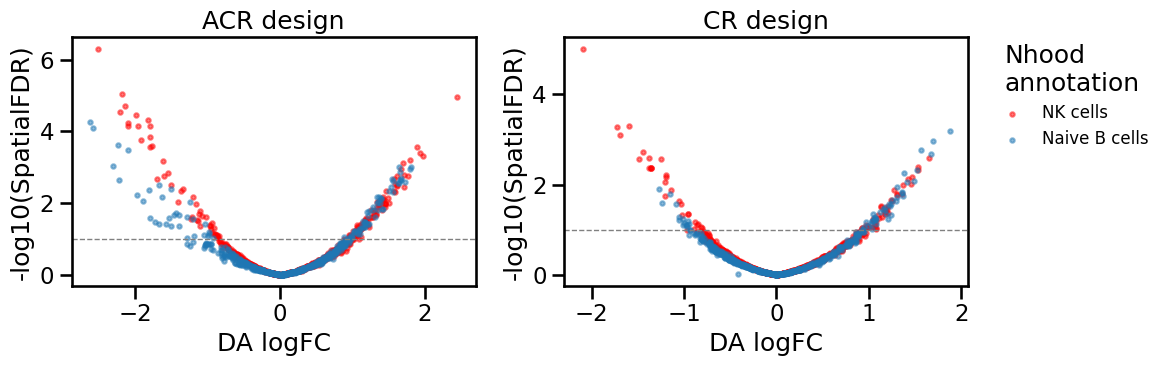

In [145]:
with plt.rc_context({'figure.figsize':[12,4]}):
    plt.subplot(1,2,1);
    # plt.plot( adata.uns['nhood_adata'].obs['logFC'], -np.log10( adata.uns['nhood_adata'].obs['SpatialFDR']), '.', color='grey',label='all');
    plt.scatter(ACR_signif_nk_cells['logFC'], -np.log10(ACR_signif_nk_cells['SpatialFDR']), s=10, alpha=0.5,label='NK cells', color='red');
    plt.scatter(ACR_signif_b_cells['logFC'], -np.log10(ACR_signif_b_cells['SpatialFDR']),s=10, alpha=0.5,label='Naive B cells');
    plt.ylabel('-log10(SpatialFDR)'); plt.xlabel('DA logFC');
    plt.axhline(y=1, color='grey', linewidth=1, linestyle='--'); ## horizontal
    # plt.hist(ACR_signif_b_cells['logFC'], label='ACR - B cells', bins=30);
    plt.title("ACR design");

    plt.subplot(1,2,2);
    plt.scatter(CR_signif_nk_cells['logFC'], -np.log10(CR_signif_nk_cells['SpatialFDR']), s=10, alpha=0.5, label='NK cells', color='red');
    plt.scatter(CR_signif_b_cells['logFC'], -np.log10(CR_signif_b_cells['SpatialFDR']),s=10, alpha=0.5,label='Naive B cells');
    plt.ylabel('-log10(SpatialFDR)'); plt.xlabel('DA logFC');
    plt.legend(
      bbox_to_anchor=(1.05, 1), # relative position on x and y axis (> 1 indicates outside of axis)
      loc='upper left', # equiv to hjust/vjust in ggplot
      borderaxespad=0, # The pad between the axes and legend border, in font-size units.
      frameon=False,
      title='Nhood\nannotation',
      fontsize=12, # label fontsize
      )
    plt.axhline(y=1, color='grey', linewidth=1, linestyle='--'); ## horizontal
    plt.title("CR design");
    plt.tight_layout();
    plt.savefig(figdir+'naiveB_NK_volcano.pdf')
    # plt.hist(CR_signif_nk_cells['logFC'], label='NK cells', bins=30);
    # plt.hist(CR_signif_b_cells['logFC'], label='B cells', bins=30);
    # plt.legend()

---

---